# Построение предсказательной модели оттока сотрудников

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
Всего есть две задачи: основная и вспомогательная. 

1. Вспомогательная — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

* Почему бизнесу это важно: предпологается, что удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. Для оценки качества моделей использует собственную метрику SMAPE, не включённую в библиотеку. Модель должна показать результат: SMAPE ⩽ 15. 

* Формула SMAPE:

$$
\text{SMAPE} = \frac{100}{n} \sum_{i=1}^{n} \frac{|F_i - A_i|}{\frac{|A_i| + |F_i|}{2}}
$$

где $А_i$ - фактическое значение, $F_i$ - предсказаное значение, а n - количество наблюдений. 

2. Основаная задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

* Качество моделей будет оценено стандартной метрикой ROC-AUC. 
* Метрика должна быть такой: ROC-AUC ≥ 0.91.


**Описание и назначение предоставленных данных:**

1. Для решения вспомогательной задачи: 
* id — уникальный идентификатор сотрудника;
* dept — отдел, в котором работает сотрудник;
* level — уровень занимаемой должности;
* workload — уровень загруженности сотрудника;
* employment_years — длительность работы в компании (в годах);
* last_year_promo — показывает, было ли повышение за последний год;
* last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
* supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
* salary — ежемесячная зарплата сотрудника;
* job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.
2. Для решения основной задачи: 
* Добавляется новый столбец quit, в котором говорится уволился ли сотрудник из кампании. 



**Название предоставленных файлов:**

1. Для вспомогательной задачи: 
* train_job_satisfaction_rate.csv - Тренировочная выборка,
* test_features.csv - входные признаки тестовой выборки,
* test_target_job_satisfaction_rate.csv - целевой признак тестовой выборки.
2. Для основной задачи: 
* train_quit.csv - тренировочная выборка,
* test_features.csv - входные признаки тестовой выборки те же, что и в прошлой задаче,
* test_target_quit.csv - целевой признак тестовой выборки.

Используемые библиотеки и инструменты, обновление актуальности библиотек:

In [1]:
!pip install shap -q
!pip install phik -q
!pip install --upgrade scikit-learn

import shap 
import pandas as pd
import numpy as np 
import phik
from matplotlib import pyplot as plt
import seaborn as sns 
from scipy import stats as st 
import sklearn
from IPython.display import display
import shap

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier 
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
recall_score, precision_recall_curve, roc_auc_score, make_scorer)
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

## Построение регрессионной модели удовлетворённости сотрудников

### Первоначальное знакомство с данными

In [2]:
train_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_satisfaction = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

for i in [train_satisfaction, test_features, test_target_satisfaction]:
    print(i.info())
    display(i.head(10))
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


Выводы:

1. Данные соовествуют заявленным и верно прочитаны. 

2. Выявленные проблемы:

* Некоректный тип данных некоторых столбцов. 
* Видно наличие пропусков. 
* Порядок строк верных значений целевого признака отличается от порядка строк остальных признаков. 





### Предобработка данных 

Создадим функции для предобработки данных:

In [3]:
def vision(data):
    display(data.head(5))
    return data.info()

def defects(data):
    print(f'Количество явных дубликатов: {data.duplicated().sum()}')
    pass_ = pd.DataFrame(data.isna().sum()).style.set_table_attributes('style="width: 60%; margin: auto;"').set_caption('Количество пропусков:')
    return(pass_)

def obvious_duplicates(data, column):
    display(pd.DataFrame(data[column].value_counts()).style.set_table_attributes('style="width: 60%; margin: auto;"'))
    print()
    
def get_rows_with_missing_values(data):
    display(data[data.isnull().any(axis=1)])
    print(f"Число строк с хотя бы одним пропуском: {len(data[data.isnull().any(axis=1)])}")
    print(f"Доля строк с пропусками: {len(data[data.isnull().any(axis=1)])/len(data)}")
    
def box(data):
    numerical_cols = data.select_dtypes(include=['number']).columns
    display(data.describe())
    for i in numerical_cols:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=data[i])
        plt.title(i)
        plt.xticks(rotation=45) 
        plt.grid()
        plt.show()
        Q1 = data[i].quantile(0.25)
        Q3 = data[i].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        anomalies = data[(data[i] < lower_bound) | (data[i] > upper_bound)]
        print(f'Количество выбивающихся значений в {i}: {len(anomalies)}')
        
def ID (data):
    print(data['id'].duplicated().sum())

#### train_job_satisfaction_rate

In [4]:
vision(train_satisfaction)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


ID не число. Изменим тип данных. 

In [5]:
train_satisfaction['id'] = train_satisfaction['id'].astype('object')

In [6]:
defects(train_satisfaction)

Количество явных дубликатов: 0


,0
id,0
dept,6
level,4
workload,0
employment_years,0
last_year_promo,0
last_year_violations,0
supervisor_evaluation,0
salary,0
job_satisfaction_rate,0


Посмотрим детальнее на этих пользователей. 

In [7]:
get_rows_with_missing_values(train_satisfaction)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Число строк с хотя бы одним пропуском: 10
Доля строк с пропусками: 0.0025


Пропусков очень мало относительно общего числа. Можно спокойно удалить их. 

In [8]:
train_satisfaction = train_satisfaction.dropna()

Посмотрим на наличие неявных дубликатов: 

In [9]:
for i in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    obvious_duplicates(train_satisfaction, i)

,dept
sales,1508
technology,866
purchasing,610
marketing,550
hr,456


,level
junior,1888
middle,1744
sinior,358


,workload
medium,2060
low,1197
high,733


,last_year_promo
no,3870
yes,120


,last_year_violations
no,3432
yes,558


Неявных дубликатов не выявлено. 

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3990.000000,3990.000000,3990.000000,3990.000000
mean,3.722055,3.475188,33953.383459,0.533772
std,2.543715,1.009238,14907.247698,0.225353
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


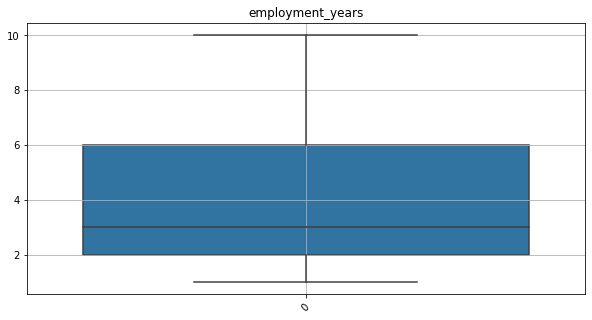

Количество выбивающихся значений в employment_years: 0


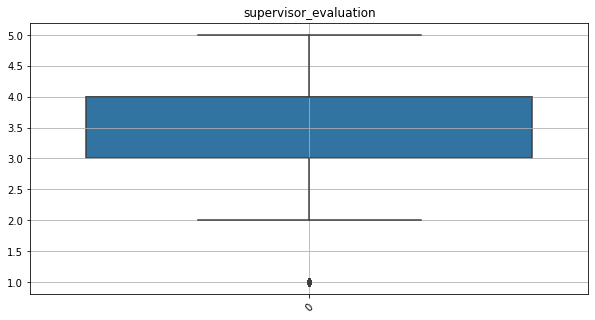

Количество выбивающихся значений в supervisor_evaluation: 201


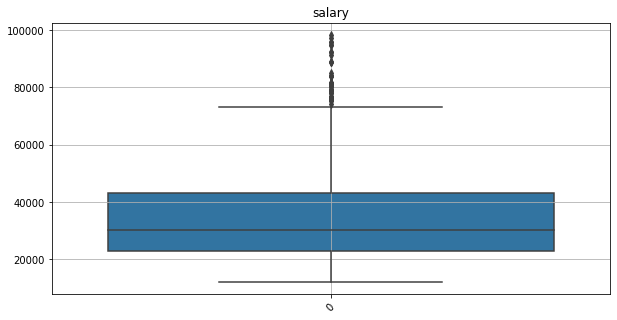

Количество выбивающихся значений в salary: 60


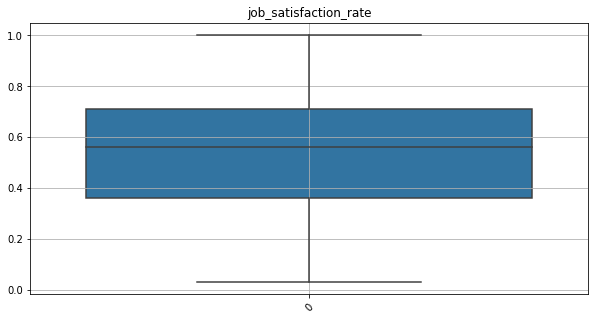

Количество выбивающихся значений в job_satisfaction_rate: 0


In [10]:
box(train_satisfaction)

Выбивающиеся значения есть в двух столбцах: supervisor_evaluation и salary. Рассмотрим их по отдельности. 

Единица, как оценка сотрудника, вполне возможное значение, хоть и маловероятное. Это вполне согласуется с данными, так как лишь около 5% сотрудников получили такие оценки руководителей.

Отклонения во втором столбце тяжело оценить на реалистичность, так как не указано в какой валюте выдаются зарплаты и за какой рабочий период. Тем не менее, вполне возможно, что узкая часть наиболее квалифицированных специалистов или руководителей будет иметь зарплаты существено более высокие, чем основная масса сотрудников. Проверим это предположение. 

In [11]:
def deviation(data):

    Q1 = data['salary'].quantile(0.25)
    Q3 = data['salary'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    highly_professional_staff = data[(data['level']=='sinior')&
    (data['salary']>upper_bound)]
    print(f'Число senior-сотрудников с выбивающимися ЗП: {len(highly_professional_staff)}')
    
deviation(train_satisfaction)

Число senior-сотрудников с выбивающимися ЗП: 60


Также проверим есть ли разные строки с одним ID. Это возможно, если ID привязано к одному физическому лицу и не изменяется при смене отдела или уровня сотрудника. 

In [12]:
ID(train_satisfaction)

0


Совпадений нет, а значит и в тестовых данных данных должна быть такая ситуация. 

#### test_features

In [13]:
vision(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Преобразуем тип данных столбца ID.

In [14]:
test_features['id'] = test_features['id'].astype('object')

In [15]:
defects(test_features)

Количество явных дубликатов: 0


,0
id,0
dept,2
level,1
workload,0
employment_years,0
last_year_promo,0
last_year_violations,0
supervisor_evaluation,0
salary,0


In [16]:
for i in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    obvious_duplicates(test_features, i)

,dept
sales,763
technology,455
marketing,279
purchasing,273
hr,227
,1


,level
junior,974
middle,854
sinior,171


,workload
medium,1043
low,593
high,363
,1


,last_year_promo
no,1937
yes,63


,last_year_violations
no,1738
yes,262


Есть проблема с не указанными категориями сотрудников. 

In [17]:
get_rows_with_missing_values(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
312,471990,sales,NaN,low,1,no,no,3,12000
1196,832342,NaN,junior,medium,1,no,no,4,28800


Число строк с хотя бы одним пропуском: 3
Доля строк с пропусками: 0.0015


Пропусков очень мало относительно общего числа. 

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


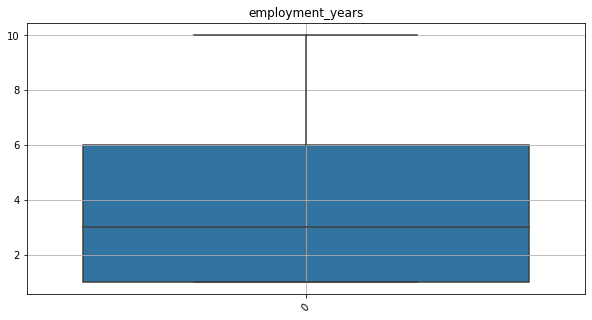

Количество выбивающихся значений в employment_years: 0


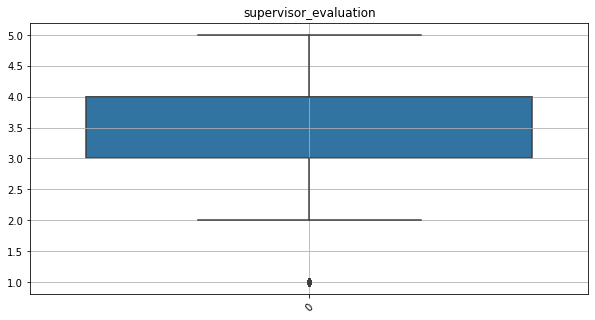

Количество выбивающихся значений в supervisor_evaluation: 88


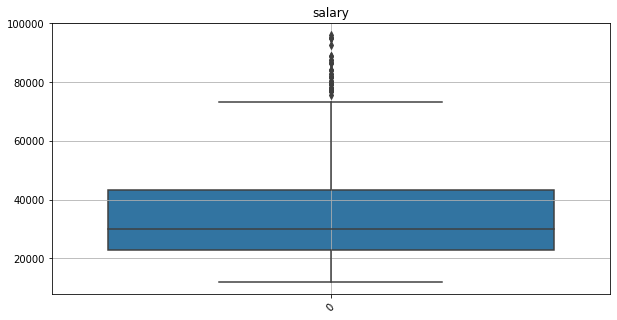

Количество выбивающихся значений в salary: 39


In [18]:
box(test_features)

Здесь схожая ситуация с тем, что было в первом наборе данных. Для верности проверим тем же методом, что и выше, столбец с зарплатами сотрудников. 

In [19]:
deviation(test_features)

Число senior-сотрудников с выбивающимися ЗП: 39


Данная особенность есть как в тренировочных, так и в тестовых данных, что в целом является хорошим знаком. Между данными есть некоторая согласованность. 

Проверим также совпадение по ID.

In [20]:
ID(test_features)

0


#### test_target_job_satisfaction_rate

In [21]:
vision(test_target_satisfaction)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [22]:
test_target_satisfaction['id'] = test_target_satisfaction['id'].astype('object')

In [23]:
defects(test_target_satisfaction)

Количество явных дубликатов: 0


,0
id,0
job_satisfaction_rate,0


,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


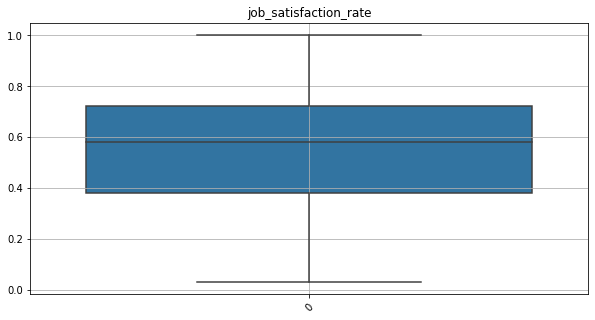

Количество выбивающихся значений в job_satisfaction_rate: 0


In [24]:
box(test_target_satisfaction)

Совпадения по ID. 

In [25]:
ID(test_target_satisfaction)

0


### Исследовательский и корреляционный анализ данных

**Ключевые цели этапа:**

1. Попытытаться найти и описать связи между целевым и другими признаками. 
2. Проверить наличие мультиколлинеарности между признаками, которые могут привести к неправильной работе моделей. 
3. Проверить насколько закономерности выявленные в тренировочных данных выполняются в тестовых. 

Создадим функции для анализа данных:

In [26]:
def vision_res(data):
    display(data.head(5))
    print('Описательные статистики:')
    print()
    return data.describe()

def hist(data, column, hue, kde, bins, figsize, centre, stat):
    plt.figure(figsize = figsize)
    plt.title(column)
    if centre == 1:
        median = np.median(data[column])
        mean = np.mean(data[column])
        plt.axvline(median, color='black', linestyle='--', label='Медиана')
        plt.axvline(mean, color='black', linestyle='-', label='Среднее')
    sns.histplot(data = data, x = column, bins = bins, hue = hue, kde = kde, stat = stat)
    
def scatterplot(data, x, y, figsize):
    plt.figure(figsize = figsize)
    plt.ylabel(y)
    plt.xlabel(x)
    sns.scatterplot(x=data[x], y=data[y])
    
def correlation(data, interval_cols):
    correlation_matrix = data.drop(columns = ['id']).phik_matrix(interval_cols = interval_cols)
    plt.figure(figsize = (15,12))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Матрица phik-корреляции')
    
def bar(data_1, data_2, column, column_1, column_2):
     
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    
    relative_counts_1 = data_1[column].value_counts(normalize=True).reset_index()
    relative_counts_1.columns = [column, 'relative_count']
    
    sns.barplot(x=column, y='relative_count', data=relative_counts_1,  ax=axs[0])
    axs[0].set_title(column+' '+column_1)
    
    relative_counts_2 = data_2[column].value_counts(normalize=True).reset_index()
    relative_counts_2.columns = [column, 'relative_count']
    
    sns.barplot(x=column, y='relative_count', data=relative_counts_2,  ax=axs[1])
    axs[1].set_title(column+' '+column_2)
    plt.show()
    plt.tight_layout()

#### train_job_satisfaction_rate

In [27]:
vision_res(train_satisfaction)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Описательные статистики:



,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3990.000000,3990.000000,3990.000000,3990.000000
mean,3.722055,3.475188,33953.383459,0.533772
std,2.543715,1.009238,14907.247698,0.225353
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


Посмотрим в целом на расспределение зарплат и удовлетворённости сотрудников кампании. 

Пунктирная линия показывает медиану, а сплошная - среднее. 

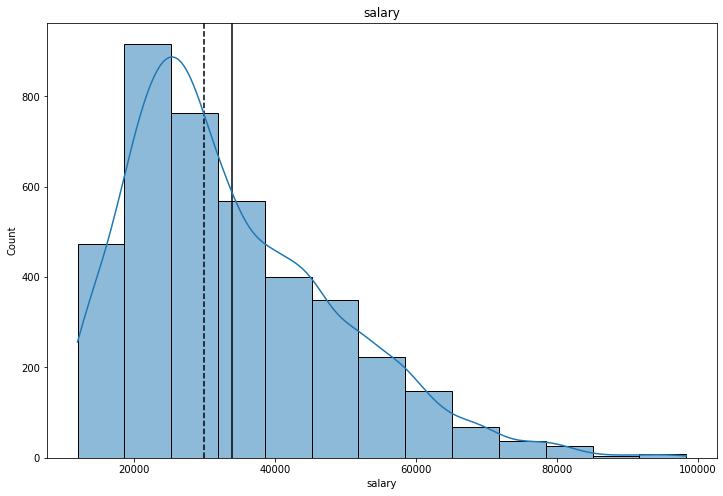

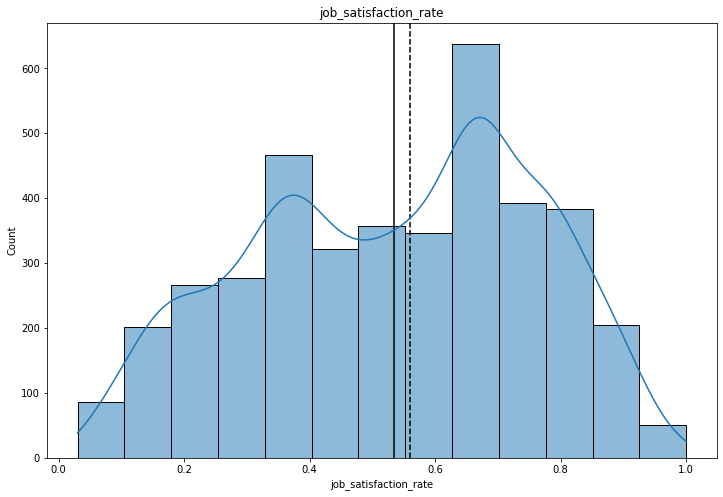

In [28]:
for i in ['salary', 'job_satisfaction_rate']:
    hist(train_satisfaction, i, None, True, 13, (12,8), 1, 'count')

* Распределение зарплат имеет колокообразную форму со смещением влево, что хорошо ложится на наши интуитивные ожидания от этого распределения. 

* Распределение же удовлетворённости имеет две выраженные вершины. В данном случае медиана и среднее сами по себе плохо передают центральную тенденцию характерную для этого распределения. 

Изучим более детально распределение удовлетворённости через призму других категориальных признаков. 

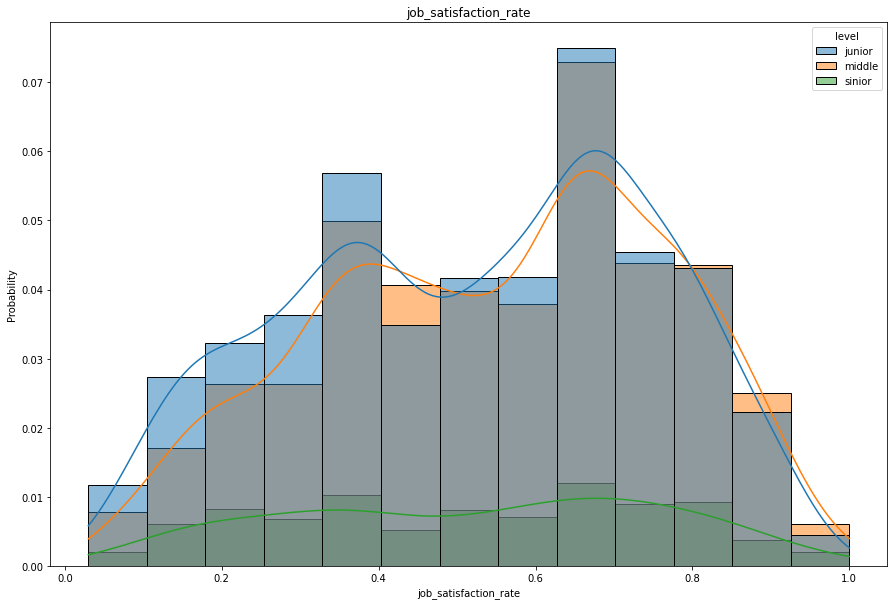

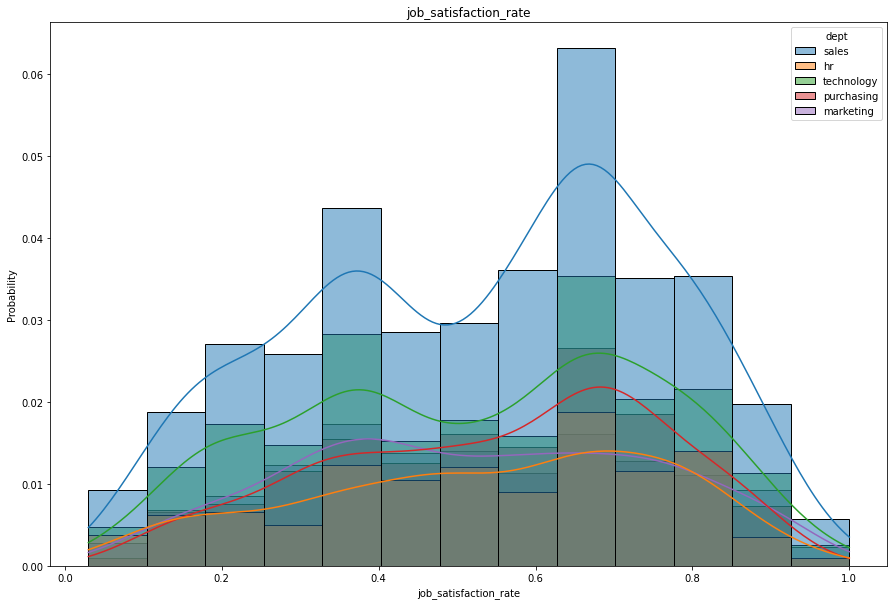

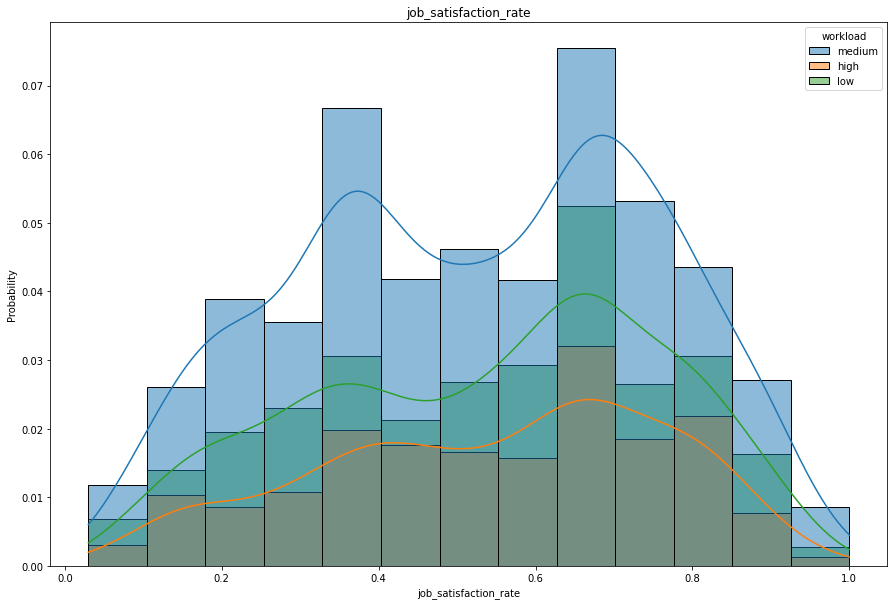

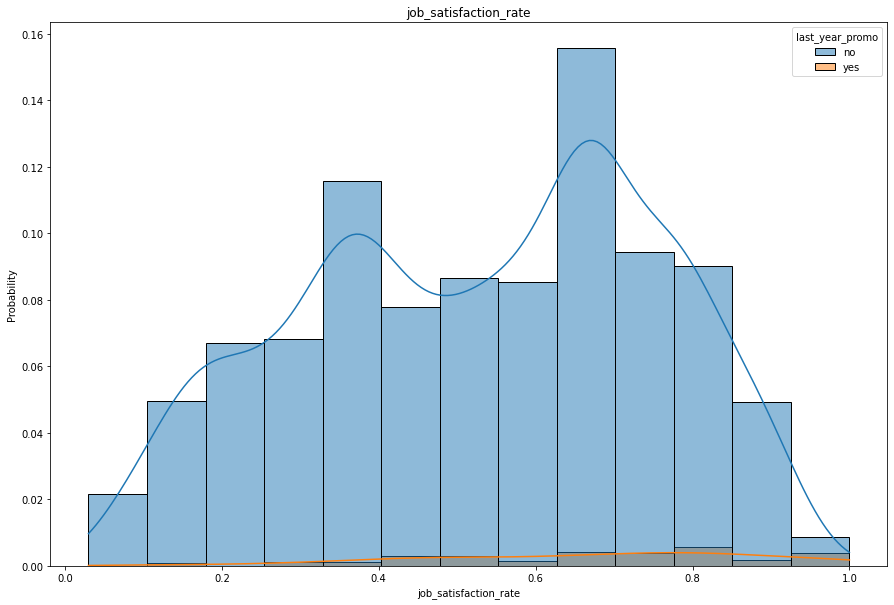

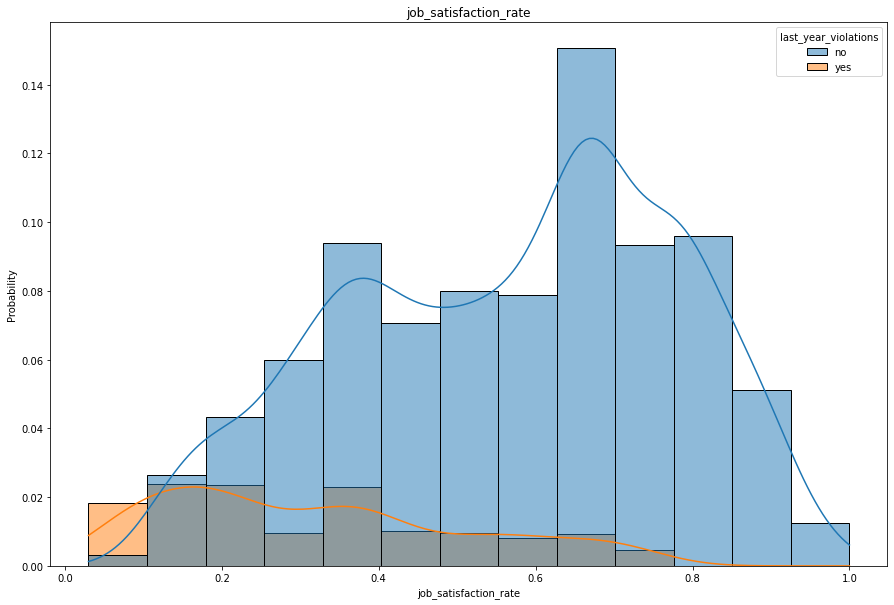

In [29]:
for i in ['level', 'dept', 'workload', 'last_year_promo', 'last_year_violations']:
    hist(train_satisfaction, 'job_satisfaction_rate', i, True, 13, (15,10), 0, 'probability')

* Для работников уровня junior и middle распределение удовлетворения практически идентичное. В том же время для senior закономерность теряет свою силу и распределение выглядит более равномерным, хоть и видны небольшие холмы. 
* Распределение по отделам очень схоже. 
* По рабочей нагрузке также видна большая схожесть. 
* Сотрудники, которые получили повышение в прошлом году, имеют более равномерное распределение удовлетворения смещённое в право. В среднем они более удовлетворены.  
* Распределение удовлетворённости сотрудников нарушивших в прошлом году трудовой договор существенно сильнее смещено влево, чем у всех остальных сотрудников. 


Изучим также распределение зарплат. 

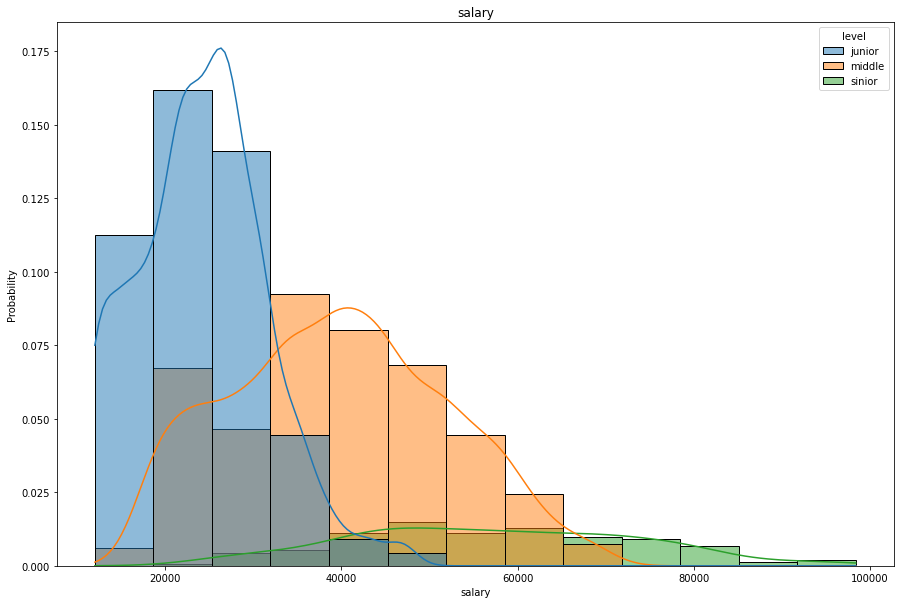

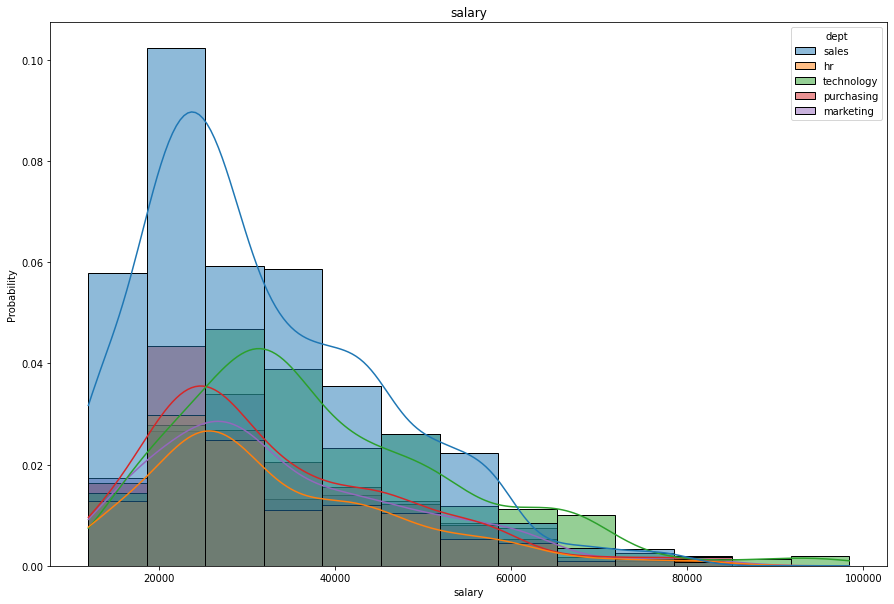

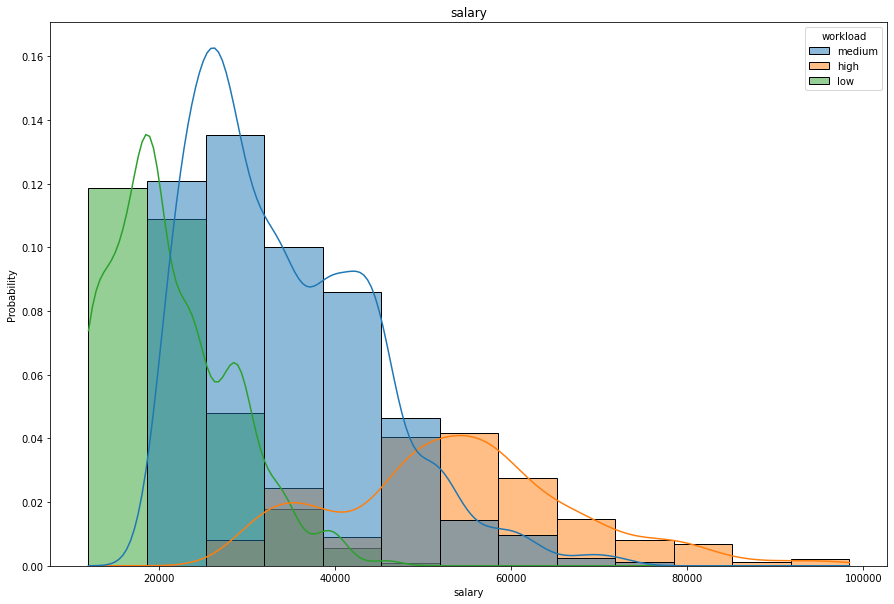

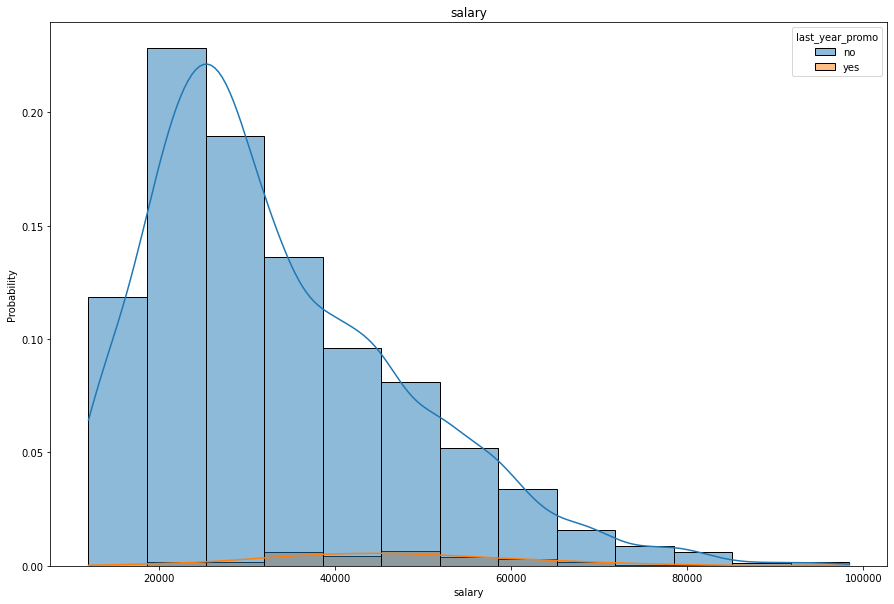

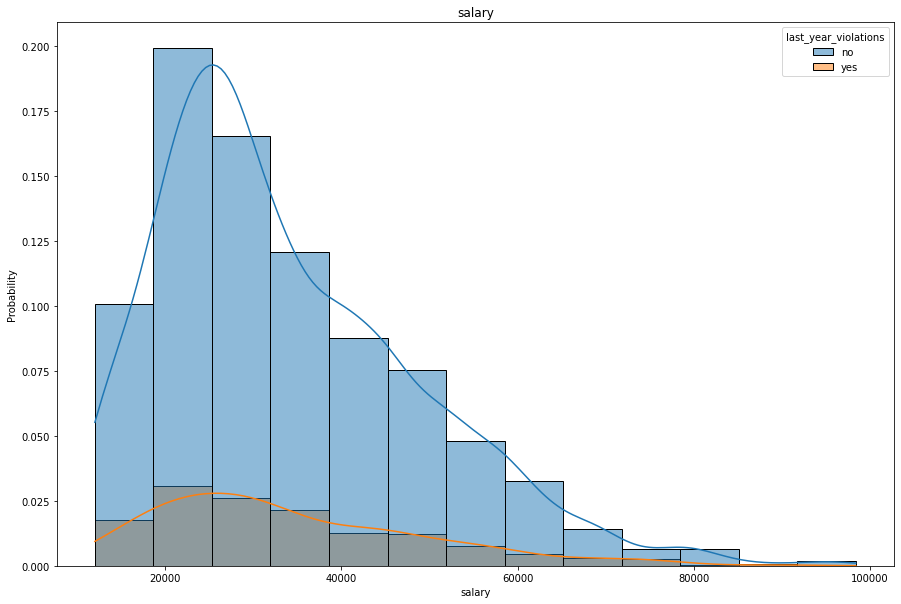

In [30]:
for i in ['level', 'dept', 'workload', 'last_year_promo', 'last_year_violations']:
    hist(train_satisfaction, 'salary', i, True, 13, (15,10), 0, 'probability')

* Чем выше уровень сотрудников, тем выше в среднем их зарплата. 
* У большинства отделом в среднем одинаковая зарплата. Выделяется разве что технологический отдел. В среднем зарплата в этом отделе выше. 
* Чем выше нагрузка сотрудника, тем больше в среднем он получает. 
* Люди получившие повышение в прошлом году в среднем получают больше. 
* В среднем люди с нарушением трудового договора и без него получают одинаково. 

Взглянем на графики рассеивания между целевым признаком и другими численными признаками. 

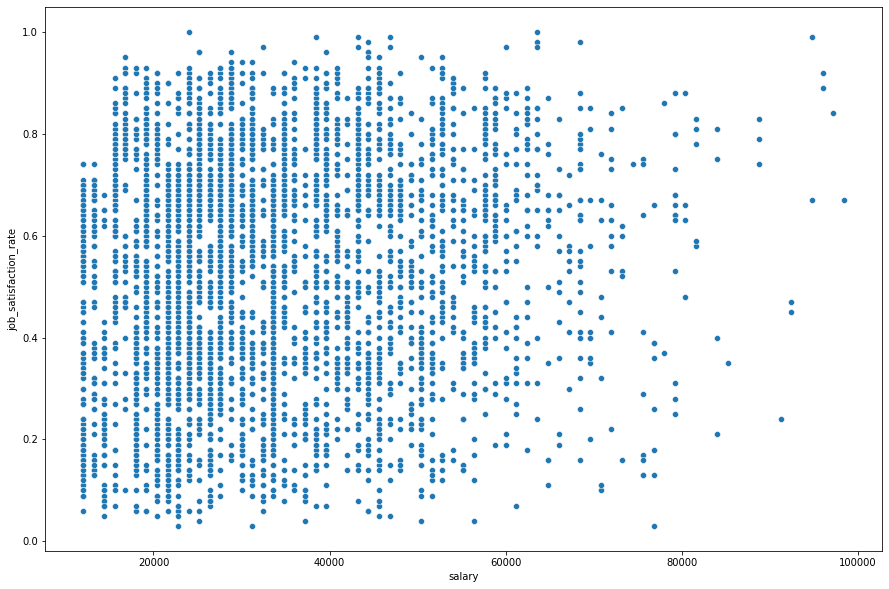

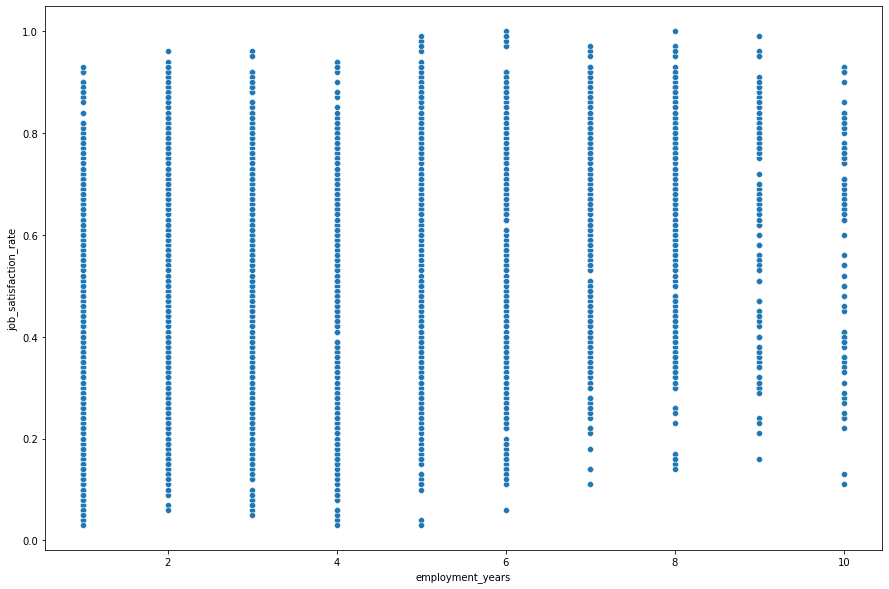

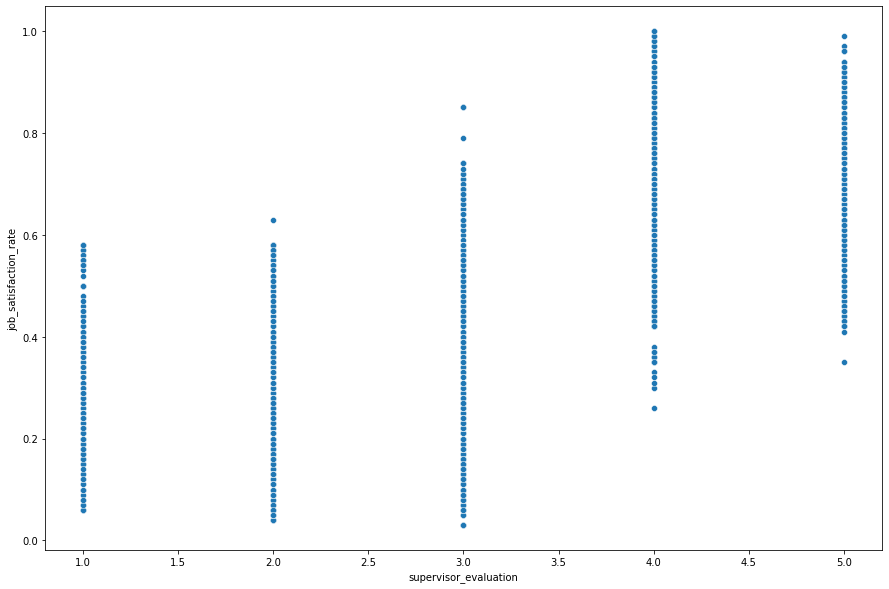

In [31]:
for i in ['salary', 'employment_years', 'supervisor_evaluation']:
    scatterplot(train_satisfaction, i, 'job_satisfaction_rate', (15,10))

* График рассеивания показывает, что связи между заработной платой и уровнем удовлетворённости нет. 
* Также почти нет связи между тем, сколько проработал человек, и его уровнем удовлетворённости. Однако можно заметить, что люди с больши сроком работы имеют более высокий показатель минимального удовлетворения в этих группах. Это становится заметно для сотрудников, которые отработали в кампании 6 и более лет. 
* А вот оценка качества работы сотрудника достаточно сильно связана с уровнем удовлетворённости. Чем выше оценка, тем выше в среднем уровень удовлетворённости, выше минимальный и максимальный её уровень. 

Взглянем также на корреляционную таблицу. 

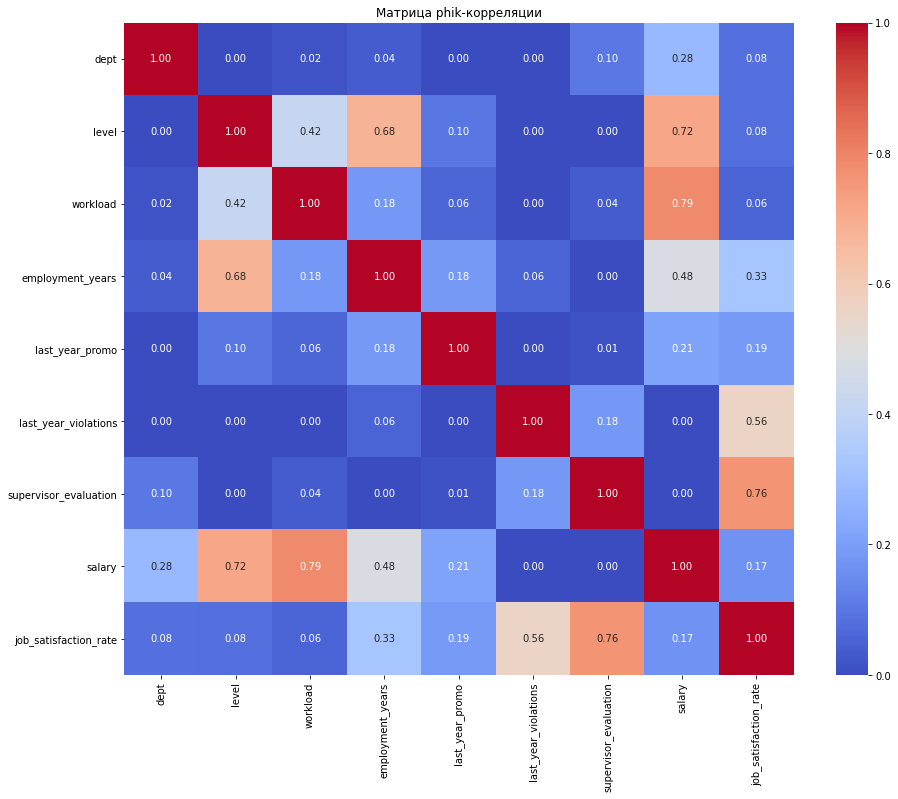

In [32]:
correlation(train_satisfaction, ['job_satisfaction_rate'])



* Оценки начальства сильнее всего коррелируют с целевым признаком, имея средне-высокую связь.
* Нарушал ли трудоговой договор сотрудник - фактор, который средне связан с целевым признаком.
* Время работы в кампании и наличие повышения в прошлом году - факторы, которые слабо влияют на целевой признак.
* Мультиколлинеарности признаков не обнаружено.


Положим, что низкий уровень удовлетворённости - это уровень удовлетворённости меньший 0,21, а высокий -  уровень удовлетворённости выше 0,44. Посмотрим на усредненных представителей обоих групп и сравним ии.

In [33]:
satisfied_employees = train_satisfaction[train_satisfaction['job_satisfaction_rate']>=0.4]
sad_employees = train_satisfaction[train_satisfaction['job_satisfaction_rate']<=0.21]
vision_res(sad_employees)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2,184592,sales,junior,low,1,no,no,2,12000,0.11
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
8,198846,hr,junior,low,1,no,no,2,13200,0.14
14,581188,marketing,middle,medium,4,no,no,2,34800,0.16
23,983772,marketing,junior,medium,1,no,no,3,26400,0.17


Описательные статистики:



,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,426.000000,426.000000,426.000000,426.000000
mean,2.481221,2.478873,30757.746479,0.147746
std,1.851136,0.713417,14717.573284,0.045016
min,1.000000,1.000000,12000.000000,0.030000
25%,1.000000,2.000000,20400.000000,0.120000
50%,2.000000,3.000000,26400.000000,0.150000
75%,4.000000,3.000000,38400.000000,0.180000
max,10.000000,3.000000,84000.000000,0.210000


In [34]:
vision_res(satisfied_employees)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44


Описательные статистики:



,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2753.000000,2753.000000,2753.000000,2753.000000
mean,3.949146,3.900109,34898.946604,0.657247
std,2.582145,0.809089,15077.386701,0.142902
min,1.000000,1.000000,12000.000000,0.400000
25%,2.000000,4.000000,24000.000000,0.540000
50%,3.000000,4.000000,31200.000000,0.660000
75%,6.000000,4.000000,44400.000000,0.770000
max,10.000000,5.000000,98400.000000,1.000000


Посмотрим на разницу в описательных статистиках между удовлетворёнными и не удовлетворёнными сотрудниками. 

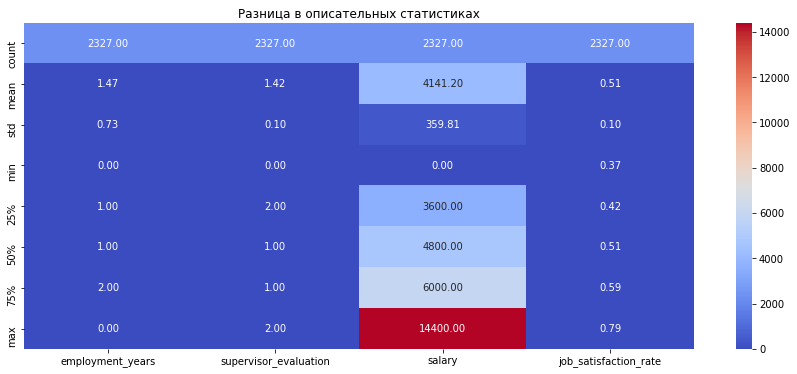

In [35]:
x = satisfied_employees.describe() - sad_employees.describe()
plt.figure(figsize=(15, 6))
sns.heatmap(x, annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title('Разница в описательных статистиках')
plt.show()

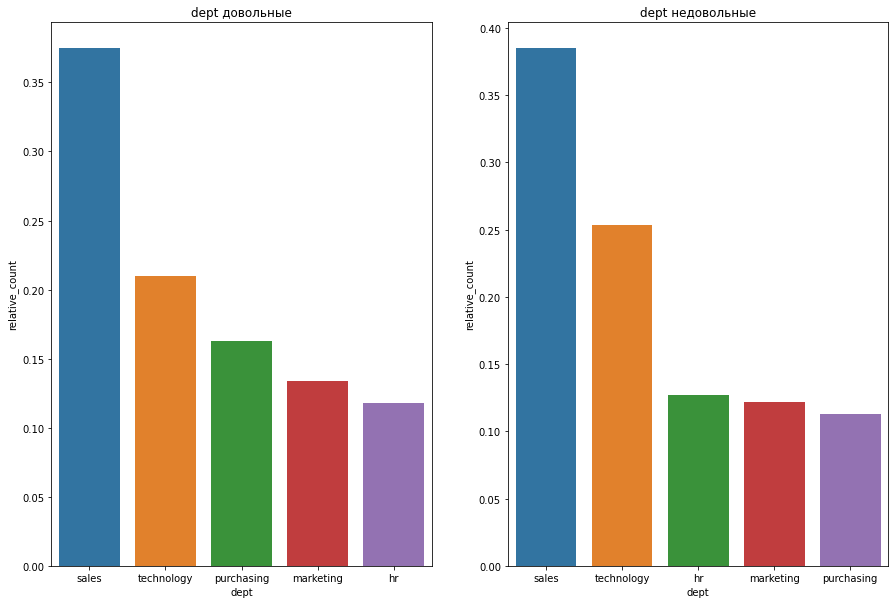

<Figure size 432x288 with 0 Axes>

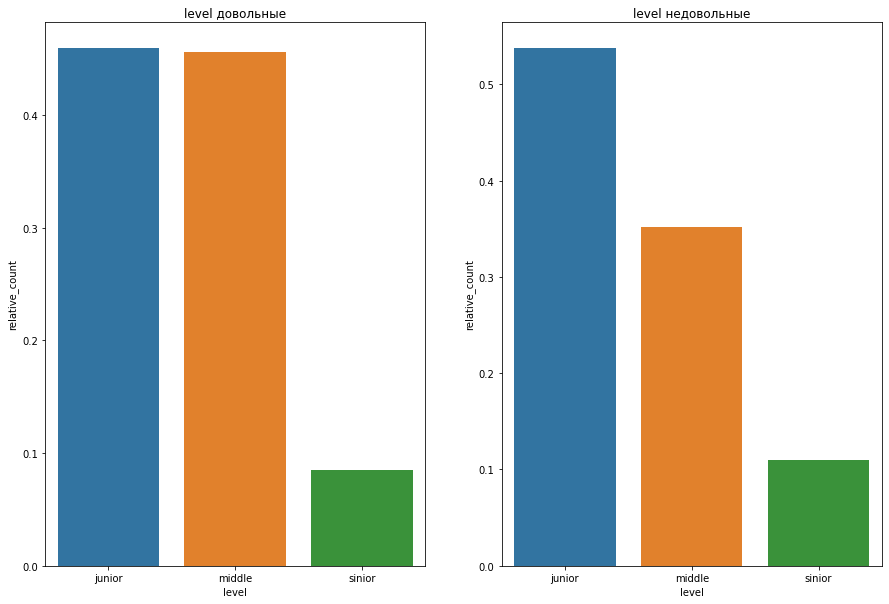

<Figure size 432x288 with 0 Axes>

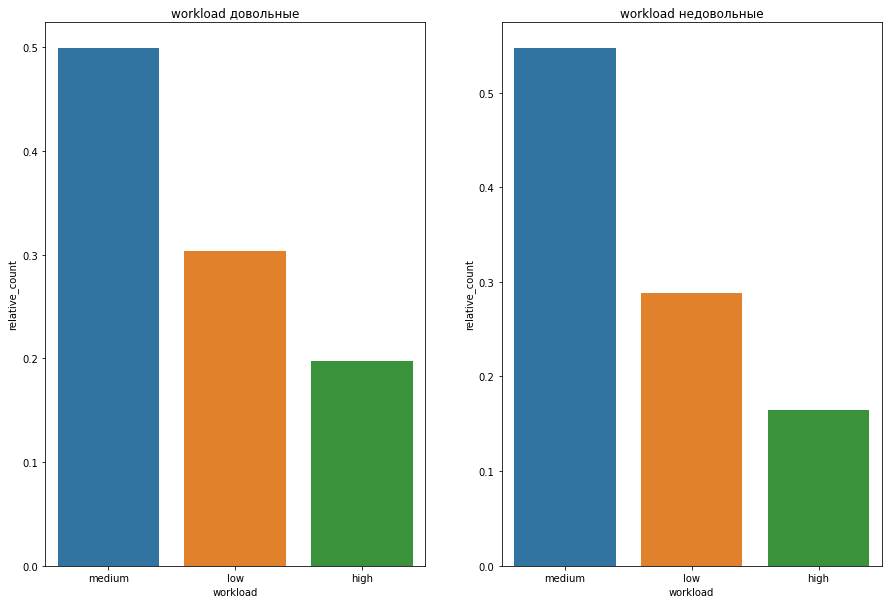

<Figure size 432x288 with 0 Axes>

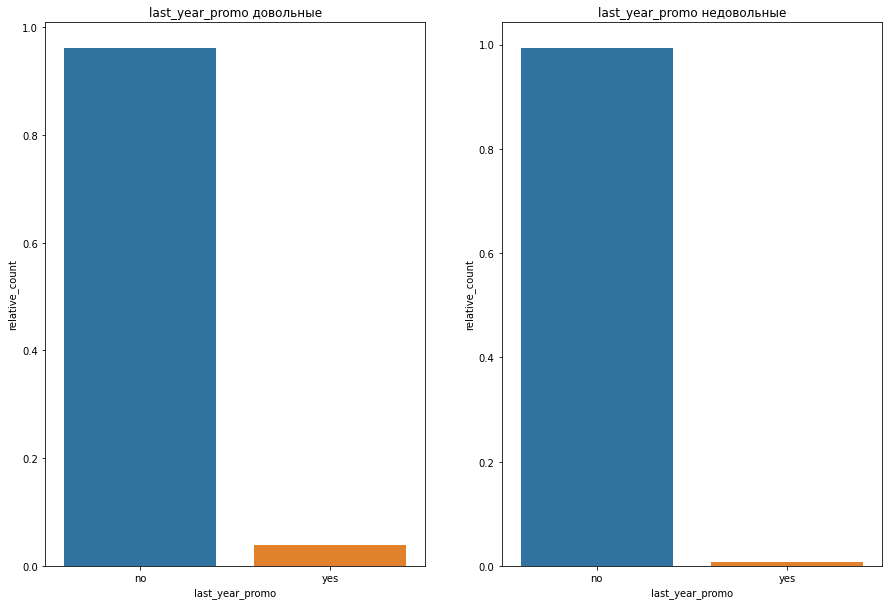

<Figure size 432x288 with 0 Axes>

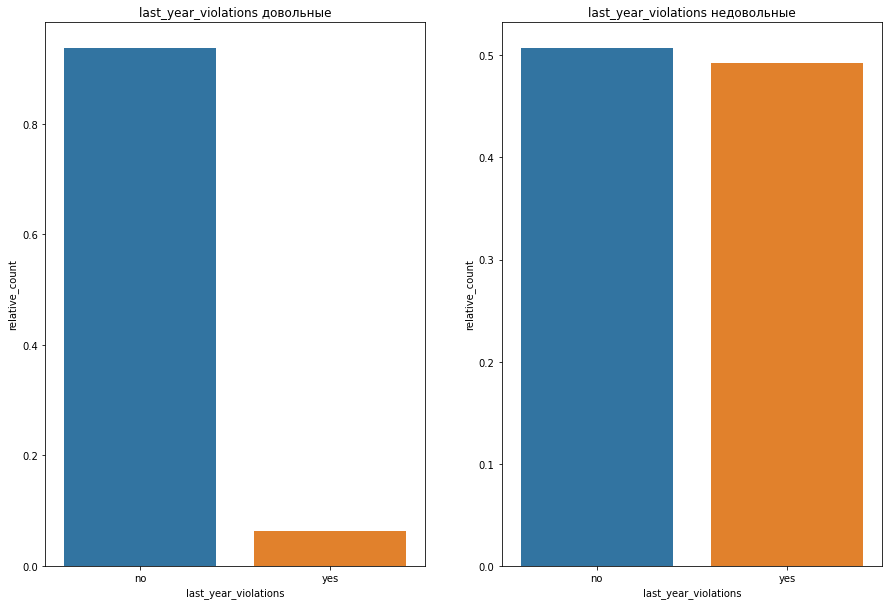

<Figure size 432x288 with 0 Axes>

In [36]:
for i in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    bar(satisfied_employees, sad_employees, i, 'довольные', 'недовольные')

* В среднем уровень зарплаты у довольных сотрудников выше, как и все основные квантили по этом признаку. 
* В среднем довольные сотрудники дольше проработали в кампании. Примерно на полтора года. 
* В среднем довольных сотрудников руководители оценивают выше на 1,4 балла. 
* В продажах больше всего как самых довольных, так и самых недовольных сотрудников. Это легко объяснимо спецификой профессии, которая не каждому может быть по душе. Примерно также можно объяснить почему сотрудники технического отдела находятся на втором месте по численности в обоих группах. Так или иначе, стоит обратить внимание на удовлетворённость сотрудников из этих отделов.
* Распределение по уровню компетентности в обоих группах не одинаково: в группе недовольных явно выделяются junior-специалисты, в отличии от группы довольных. 
* Распределение по уровню нагруженности в обоих группах практически одинаково. 
* Видно, что среди недовольных меньше доля тех, кто получил повышение, чем в группе довольных. 
* Среди недовольных почти половина нарушила трудовой договор, а в группе довольных лишь незначительная часть. 
* Довольных сотрудников существено выше.

#### test_features

In [37]:
vision_res(test_features)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Описательные статистики:



,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Посмотрим есть ли существенная разница в распределении признаков между тестовыми и обучающими данными. 

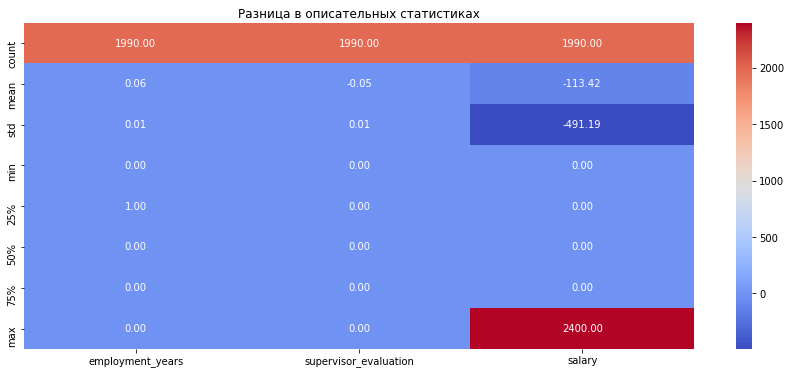

In [38]:
x = train_satisfaction.drop(columns = 'job_satisfaction_rate').describe() - test_features.describe()
plt.figure(figsize=(15, 6))
sns.heatmap(x, annot=True, cmap='coolwarm', cbar=True, fmt='.2f')
plt.title('Разница в описательных статистиках')
plt.show()

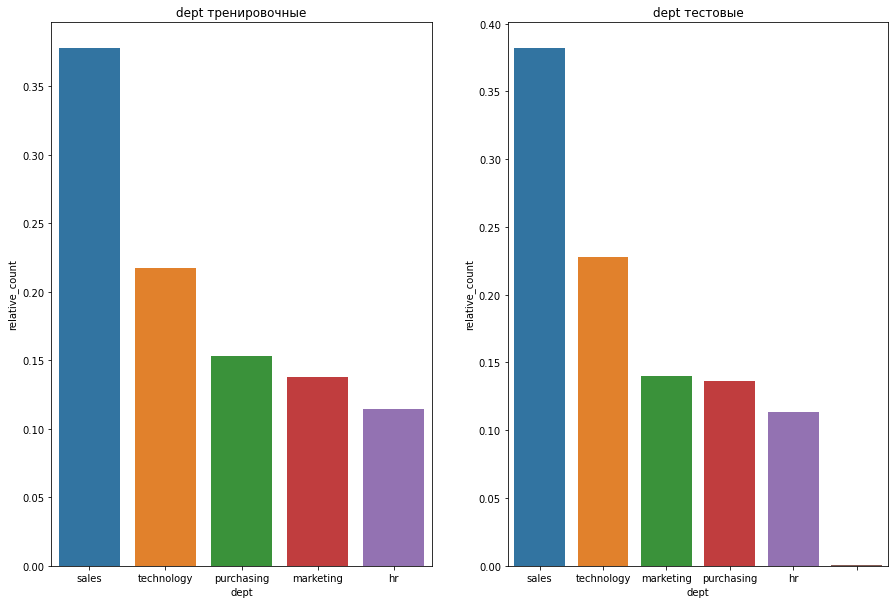

<Figure size 432x288 with 0 Axes>

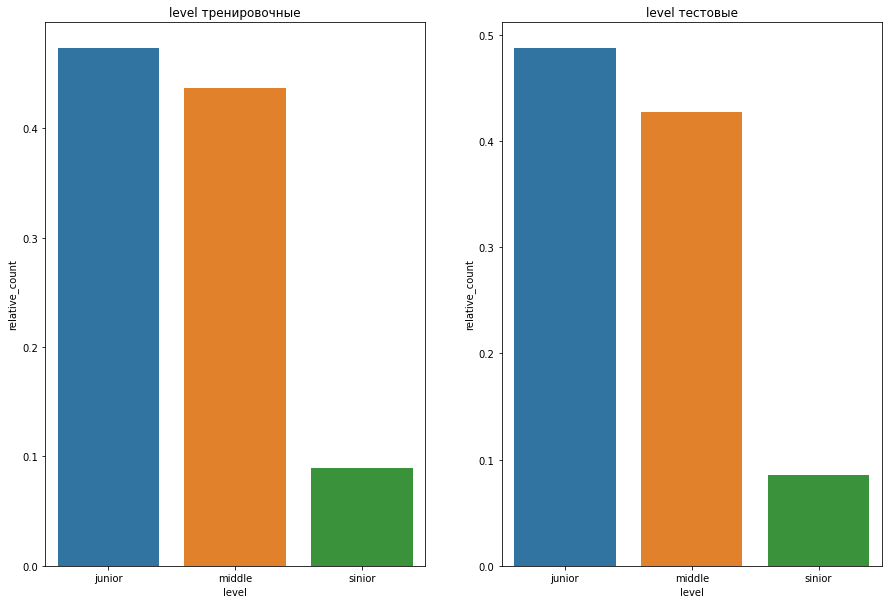

<Figure size 432x288 with 0 Axes>

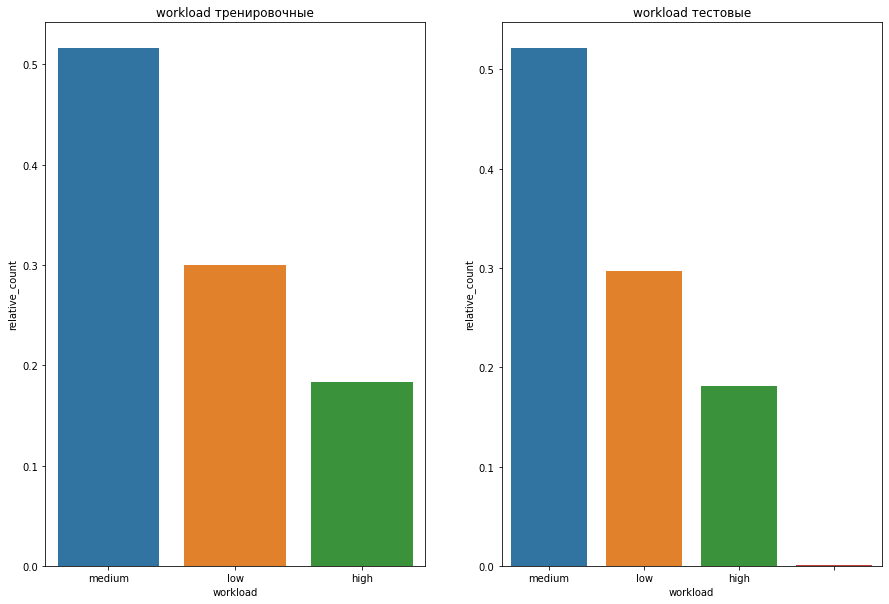

<Figure size 432x288 with 0 Axes>

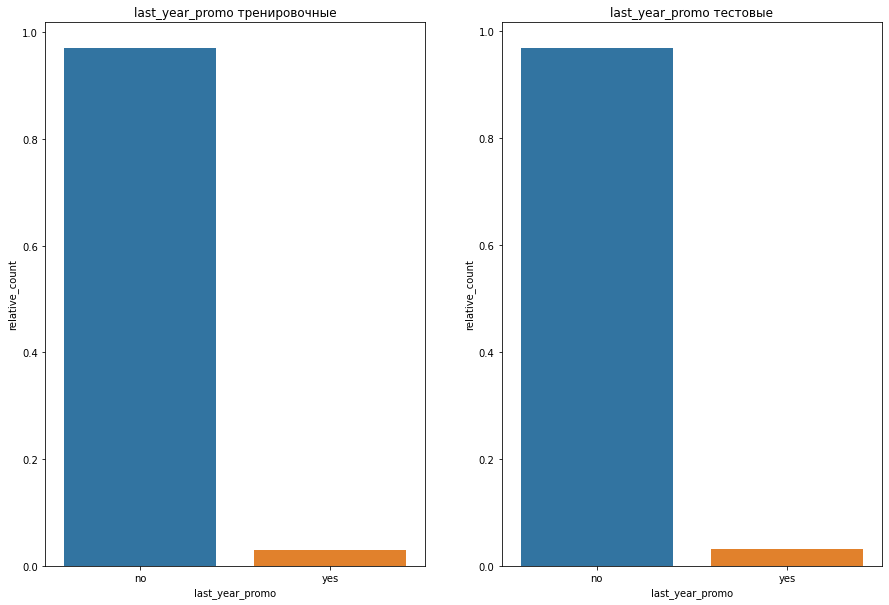

<Figure size 432x288 with 0 Axes>

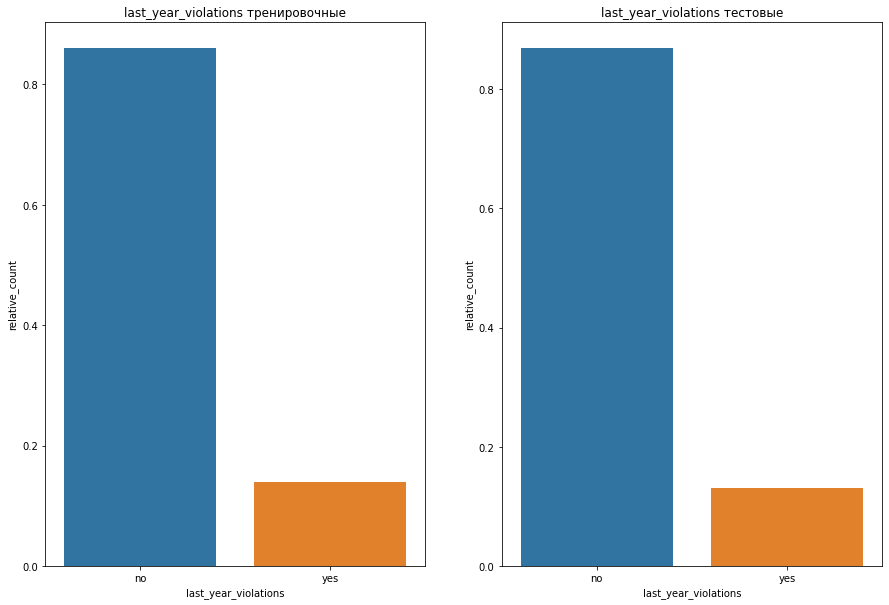

<Figure size 432x288 with 0 Axes>

In [39]:
for i in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    bar(train_satisfaction, test_features, i, 'тренировочные', 'тестовые')

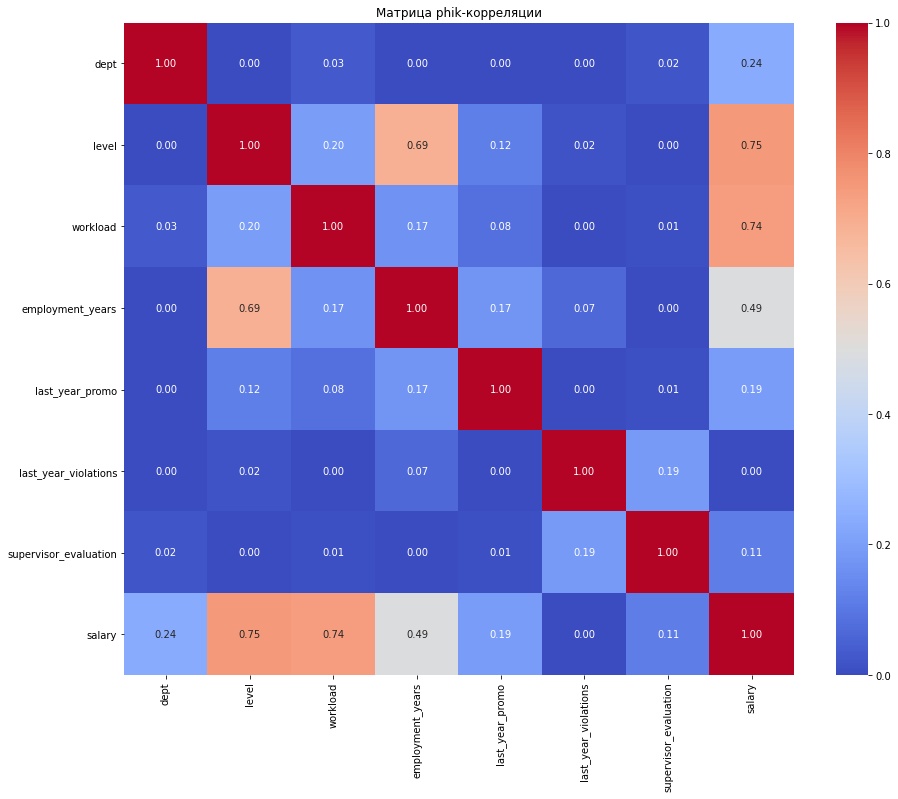

In [40]:
correlation(test_features, ['job_satisfaction_rate'])

* Тестовые данные имеют туже структуру, что и тренировочные. 

### Подготовка данных 

Удалим строки со значением целевого признака, где сотрудник имел пропуск в одном из остальных признаков. 

In [41]:
df = train_satisfaction.drop('id', axis=1)
X_train =  df.drop(['job_satisfaction_rate'], axis = 1)
y_train = df['job_satisfaction_rate']

Объединим тестовые признаки и таргет по ID, чтобы было верное соотвествие между значением целевого признака и остальными признаками для каждого сотрудника. 

In [42]:
test = pd.merge(test_features, test_target_satisfaction, on = 'id')
test = test.drop(['id'], axis = 1)
X_test = test.drop(['job_satisfaction_rate'], axis = 1)
y_test = test['job_satisfaction_rate']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3990, 8), (3990,), (2000, 8), (2000,))

In [43]:
RANDOM_STATE = 43

target = 'job_satisfaction_rate'


features = df.columns.drop(target)

num_columns = df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

levels = ['junior', 'middle', 'sinior']
workload = ['low', 'medium', 'high']

ohe_pipe = Pipeline(
    [('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]
    )

ord_levels_pipe = Pipeline(
    [('ord', OrdinalEncoder(categories = [levels], handle_unknown='use_encoded_value', unknown_value=np.nan))
    ]
    )

ord_workload_pipe = Pipeline(
    [('ord', OrdinalEncoder(categories = [workload], handle_unknown='use_encoded_value', unknown_value=np.nan))
    ]
    )


data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord_levels', ord_levels_pipe, ['level']),
        ('ord_workload', ord_workload_pipe, ['workload']),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)


pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model',  RandomForestRegressor(random_state = RANDOM_STATE))
    ]
)



### Обучение моделей

Прежде чем подбирать лучшую модель с оптимальными гиперпараметрами, создадим свою собственную метрику оценки качества моделей. 

In [44]:
def smape(y_true, y_pred):
    result = np.mean(np.abs(y_pred - y_true) /((np.abs(y_pred) + np.abs(y_true))/2))*100
    return result
    
smape_scorer = make_scorer(smape, greater_is_better=False)    

In [45]:
param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=42)],
        'model__max_depth': range(2, 11),
        'model__max_features': range(2, 12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LinearRegression(n_jobs=-1)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }
]

randomized_search = RandomizedSearchCV(pipe_final, 
param_grid, 
cv=5, 
scoring=smape_scorer,
random_state=RANDOM_STATE,
n_jobs=-1, 
error_score='raise')

randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Лучшее значение метрики SMAPE после кросс-валидации:',np.abs(randomized_search.best_score_))
SMAPE_test = smape(y_test, randomized_search.predict(X_test))
print("Значение метрики SMAPE на тестовой выборке:", SMAPE_test)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord_levels',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                       

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Посмотрим на то, как модель приняла решение. 

In [46]:
data_preprocessor.fit_transform(X_train)

best_model = randomized_search.best_estimator_.named_steps['model']
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Признак':pipe_final.named_steps['preprocessor'].get_feature_names_out(), 'Важность': feature_importances})
importance_df = importance_df.sort_values(by='Важность', ascending=False)

importance_df


,Признак,Важность
9,num__supervisor_evaluation,0.695229
8,num__employment_years,0.075278
10,num__salary,0.067146
5,ohe__last_year_violations_yes,0.053030
6,ord_levels__level,0.051178
7,ord_workload__workload,0.019820
4,ohe__last_year_promo_yes,0.011782
2,ohe__dept_sales,0.008826
0,ohe__dept_marketing,0.008088
3,ohe__dept_technology,0.008049


### Общий вывод

* Лучшей моделью оказалось дерево решений с неплохой метрикой SMAPE. Качество лучшей модели удовлетворяет поставленным в самом начале условиям. 

* Ключевой признак, которые определяет удовлетворённость сотрудника - оценка начальника. 

* Уже на исследовательском этапе было видно, что целевой признак сложным образом связан с остальными. Именно по этой причине дерево решений оказалось лучше обычной лининейной регрессии. Конечно, полиномизацией или иными манипуляциями с признаками можно было улучшить результаты и линейной регрессии, но дерево решений показывает хороший результат и без дополнительных манипуляций.

## Предсказание увольнения сотрудника из компании

### Первоначальное знакомство с данными

In [47]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

for i in [train_quit, test_target_quit]:
    print(i.info())
    display(i.head(10))
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


### Предобработка данных

#### train_quit

In [48]:
vision(train_quit)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [49]:
train_quit['id'] = train_quit['id'].astype('object')

In [50]:
defects(train_quit)

Количество явных дубликатов: 0


,0
id,0
dept,0
level,0
workload,0
employment_years,0
last_year_promo,0
last_year_violations,0
supervisor_evaluation,0
salary,0
quit,0


In [51]:
for i in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    obvious_duplicates(train_quit, i)

,dept
sales,1438
technology,928
purchasing,588
marketing,582
hr,464


,level
junior,1949
middle,1694
sinior,357


,workload
medium,2118
low,1208
high,674


,last_year_promo
no,3887
yes,113


,last_year_violations
no,3455
yes,545


,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


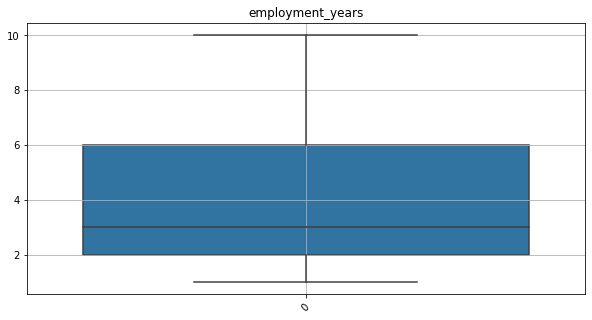

Количество выбивающихся значений в employment_years: 0


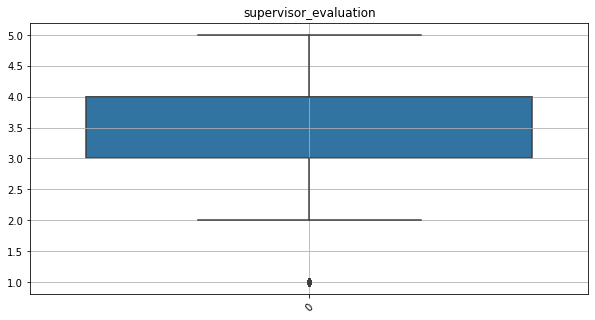

Количество выбивающихся значений в supervisor_evaluation: 202


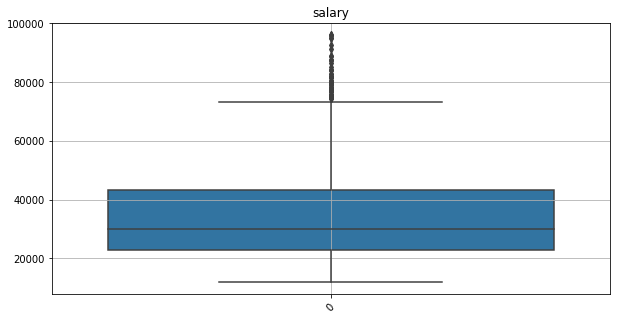

Количество выбивающихся значений в salary: 78


In [52]:
box(train_quit)

Проверим и здесь наше убеждение о том, что сотрудники с выбивающимися зарплатами - сотрудники с высоким уровнем. 

In [53]:
deviation(train_quit)

Число senior-сотрудников с выбивающимися ЗП: 78


Даннные оказались хорошего качества и практически не потребовали никакого вмешательства. 

### Исследовательский анализ данных 

На данном этапе попытаемся установить связь между увольнением и остальными признаками, в том числе и уровнем удовлетворённости. 

Сразу зададим нужные функции:

In [54]:
def bar_abs(data, column):
    train_quit_yes = train_quit[train_quit['quit'] == 'yes']
    train_quit_no = train_quit[train_quit['quit'] == 'no']
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    
    value_counts = train_quit_yes[column].value_counts()
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [column, 'count']  
    
    sns.barplot(x=column, y='count', data=value_counts_df, ax=axs[0])
    axs[0].set_title("Уволились")
    
    value_counts = train_quit_no[column].value_counts()
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [column, 'count'] 
    
    sns.barplot(x=column, y='count', data=value_counts_df, ax=axs[1])
    axs[1].set_title("Не уволились")
    
def bar_relat(column):
    train_quit_yes = train_quit[train_quit['quit'] == 'yes']
    
    result = train_quit_yes[column].value_counts()/train_quit[column].value_counts()
    result = result.reset_index()
    result.columns = [column, 'rel'] 
    plt.figure(figsize=(15, 10))
    sns.barplot(x=column, y='rel', data=result)
    plt.show()
    

    

#### Информация об удовлетворённости и увольнении в одной таблице


Тренировочные данные для первой и второй задачи имеют равное количество строк. Проверим один и тот же ли этот датасет. 

In [55]:
common_elements = train_satisfaction['id'].isin(train_quit['id'])
print("Общие элементы:\n", common_elements.value_counts())

Общие элементы:
 False    3990
Name: id, dtype: int64


Нам остаётся только использовать нашу модель для добавления признака удовлетворённости сотрудников. Таким образом мы получим возможность посмотреть на возможную связь между удовлетворённостью и увольнением. 

In [56]:
train_quit_features = train_quit.drop('quit', axis = 1)
predictions = randomized_search.best_estimator_.predict(train_quit_features)
train_quit['job_satisfaction_rate'] = predictions
train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.618571
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.829905
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.405890
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.829905
...,...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no,0.508286
3996,672059,sales,middle,high,9,no,no,4,52800,no,0.765798
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.580000
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no,0.607340


#### Непосредственный анализ 


Посмотрим на общую картину оттока сотрудников, то есть какая доля сотрудников предпочла уволится. 

In [57]:
train_quit['quit'].value_counts()/len(train_quit)

no     0.718
yes    0.282
Name: quit, dtype: float64

Около 30% сотрудников уволились, что является не малым количеством. Однако сильной ассиметрии классов нет. 


Взглянем на сотрудников с делением по категориальным признакам. 


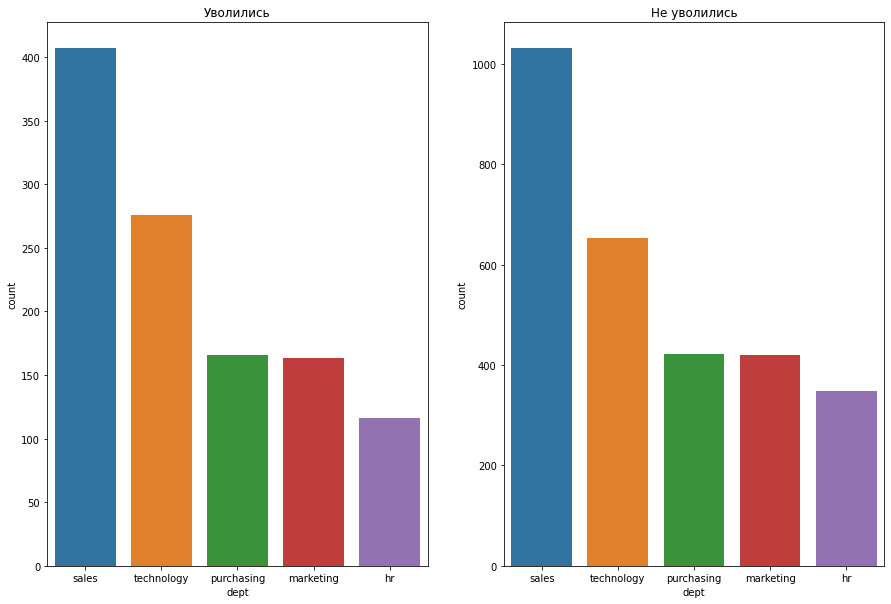

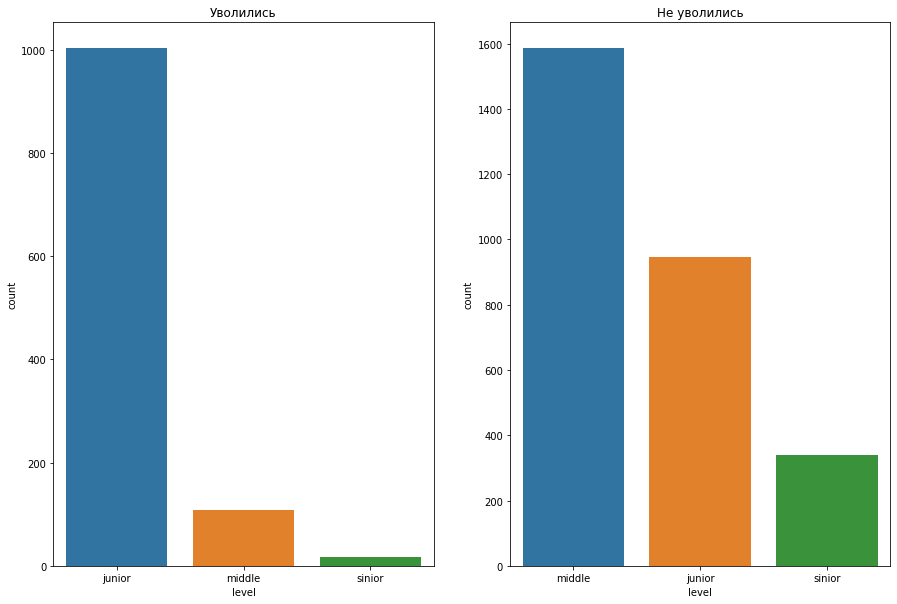

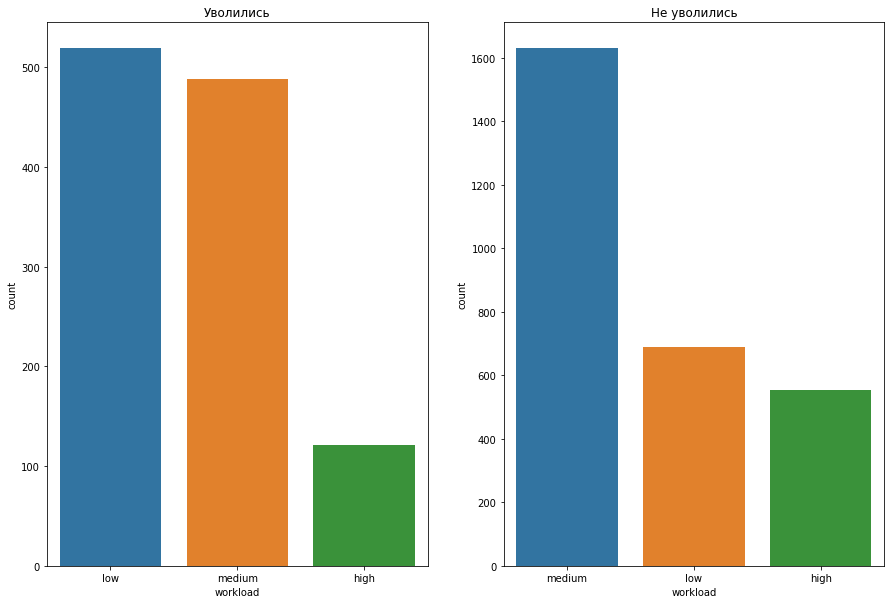

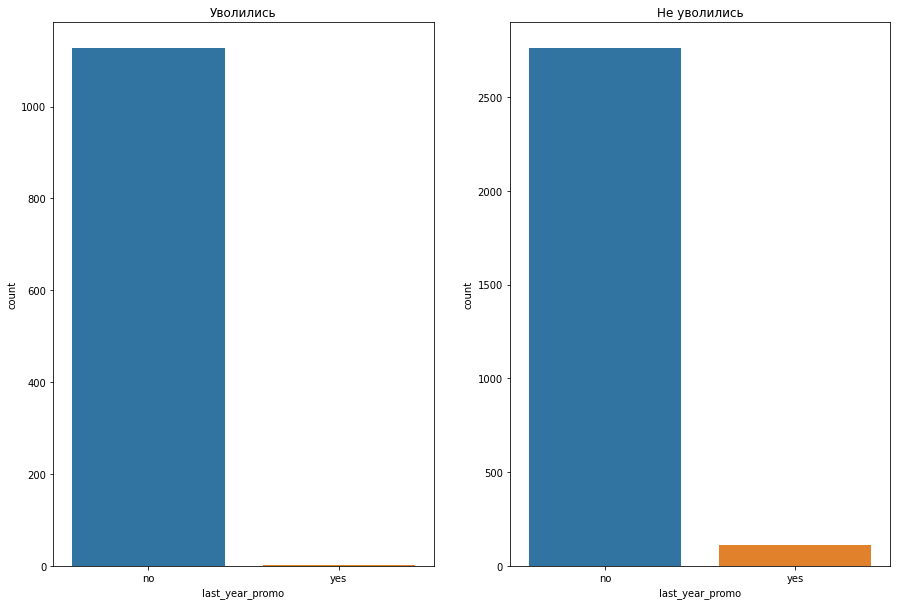

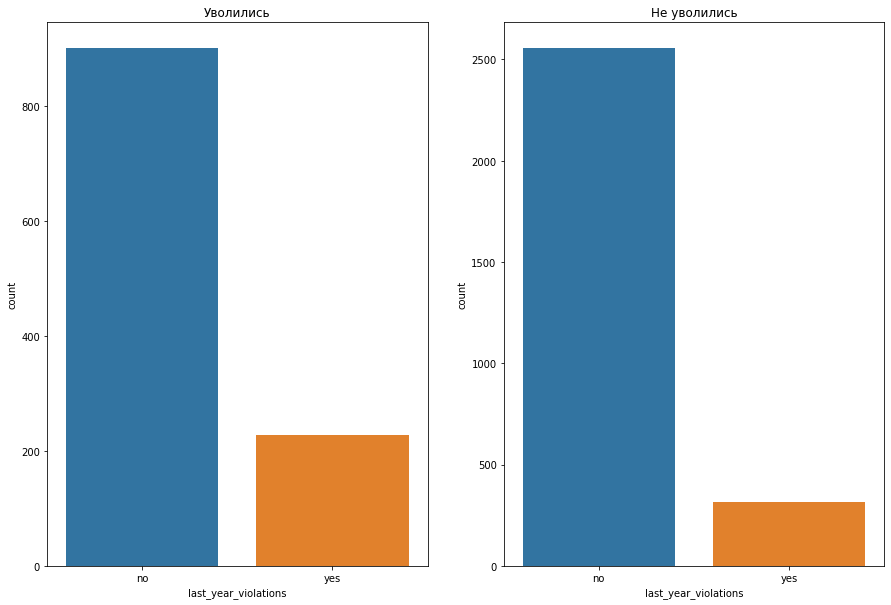

In [58]:
for i in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    bar_abs(train_quit, i)

Абсолютные значения дали мало информации. Посмотрим на относительные показатели, иначе говоря относительную частоту увольнений разных категорий сотрудников. Это позволит нам оценить вероятность увольнения. 

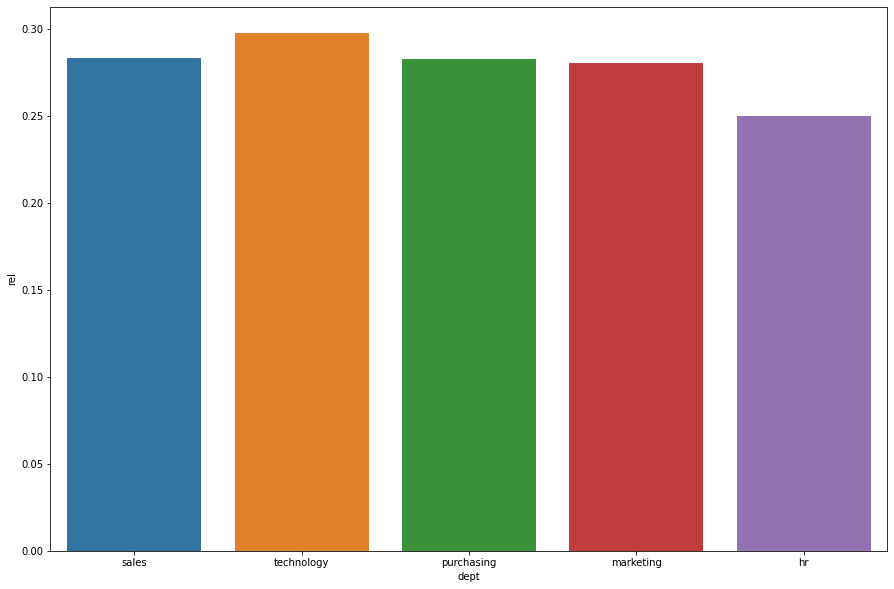

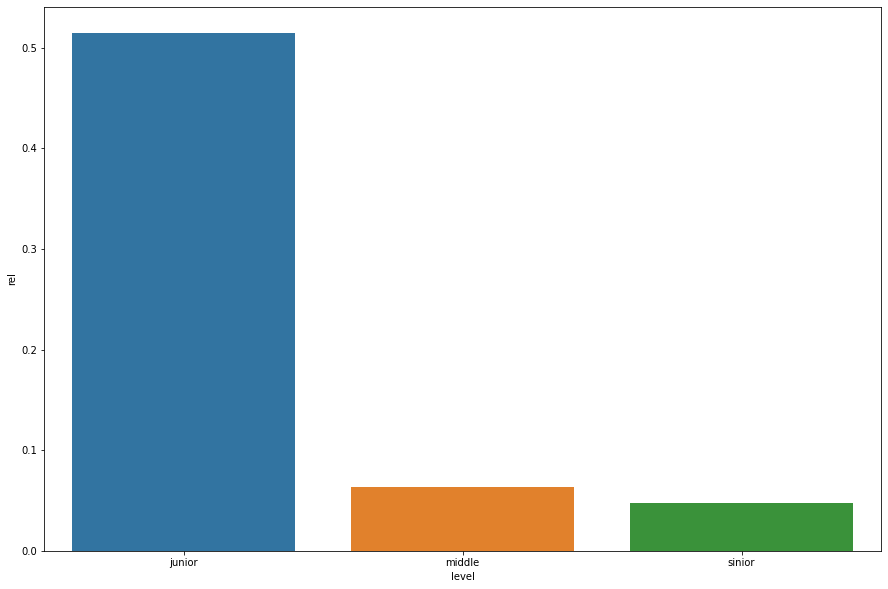

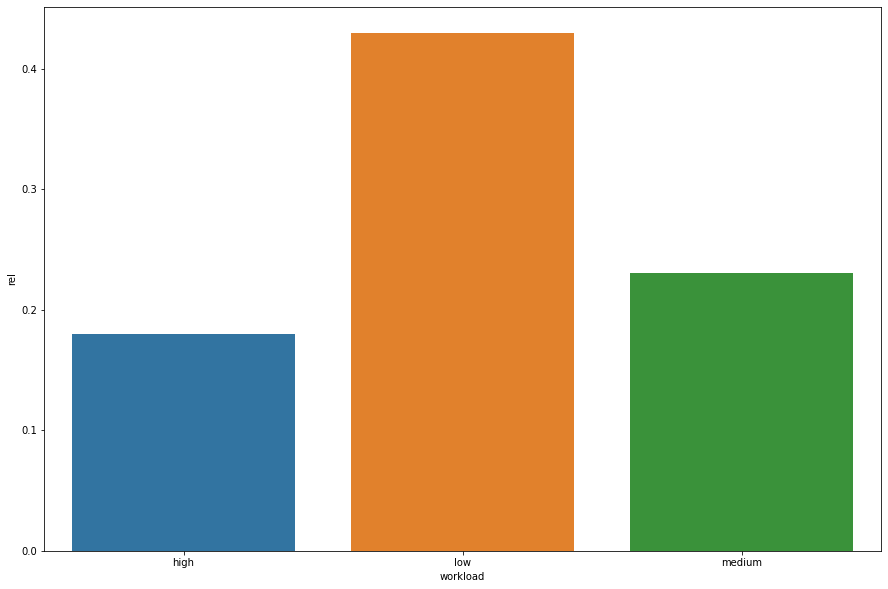

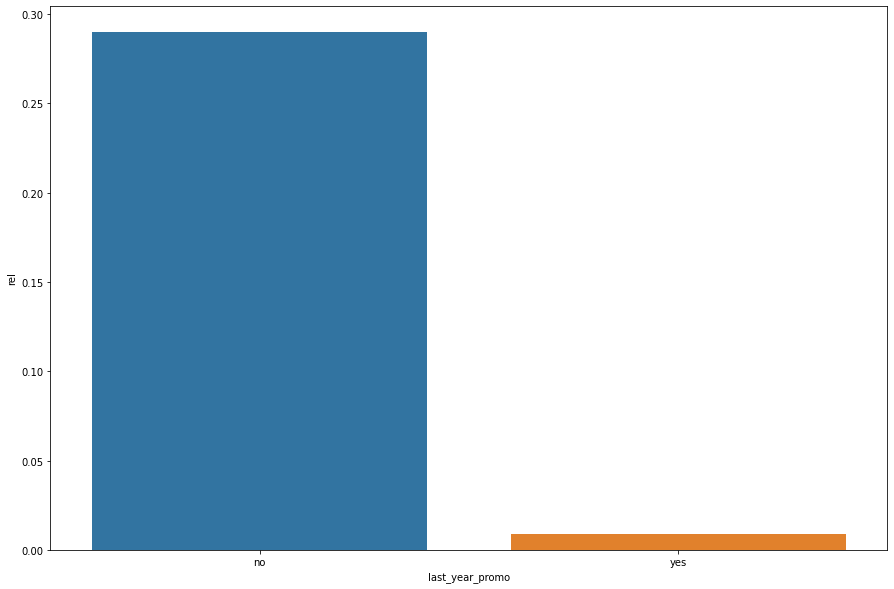

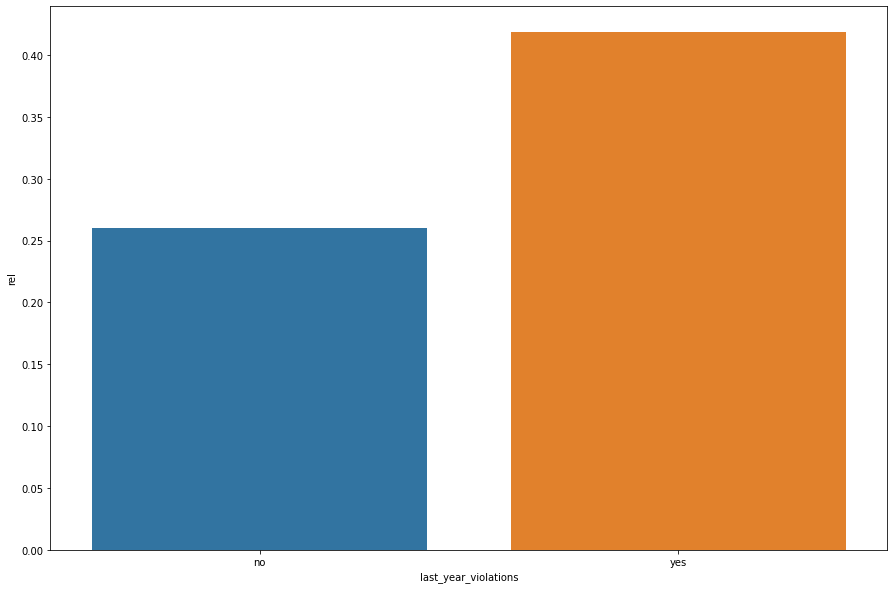

In [59]:
for i in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    bar_relat(i)


* Промежуточные выводы:

1. Вероятность увольнения в разных отделах на самом деле не сильно отличается. Однако в абсолютном выражении увольняется больше из отдела продаж, так как это многочисленный отдел. 
2. У junior-сотрудника шанс уволится самый высокий. К тому же, это самый многочисленый уровень. Около половины сотрудников на этой позиции увольняется. Причины могут быть самые различные. К примеру, сотрудник может не справляться с нагрузкой или же искать карьерный рост в иных кампаниях. Для выясненния требуется дополнительная информация. 
3. В зоне риска также находятся сотрудники, которые имеют низкую трудовую нагрузку. Тяжело сказать является ли это следствием или причиной желания уволится. Однако это точно является фактором риска. 
4. Наличие повышения существенно снижает вероятность увольнения. 
5. Нарушенный трудовой договор также является факторов риска. 

Теперь посмотрим на количественные данные:

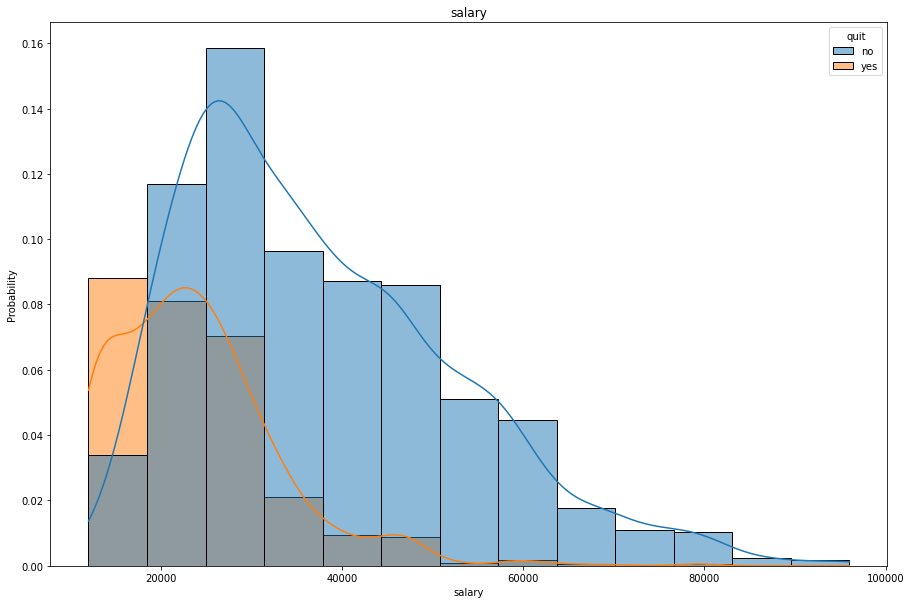

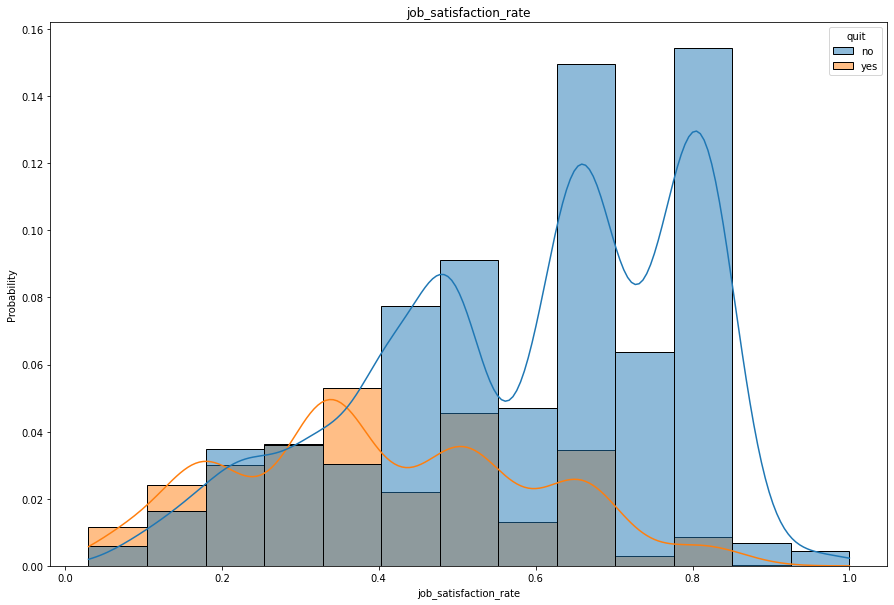

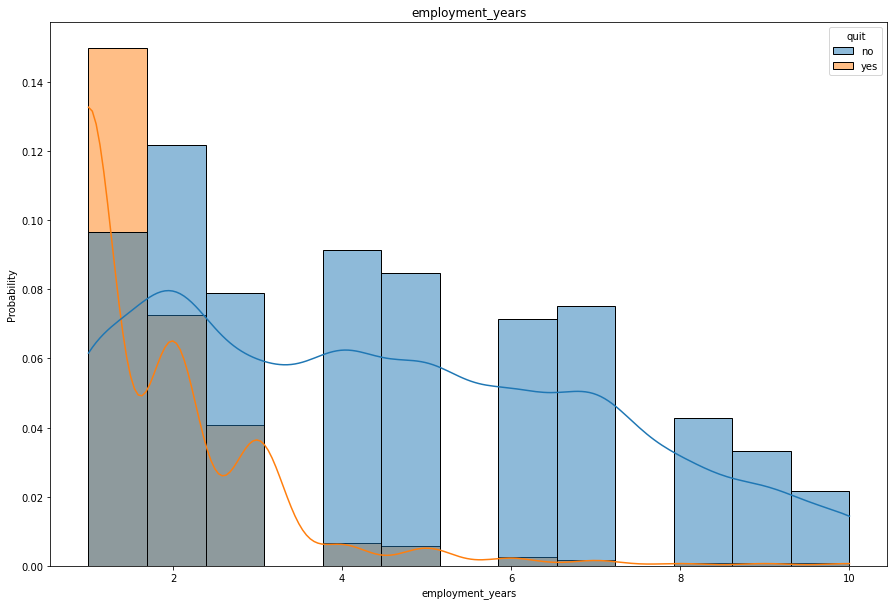

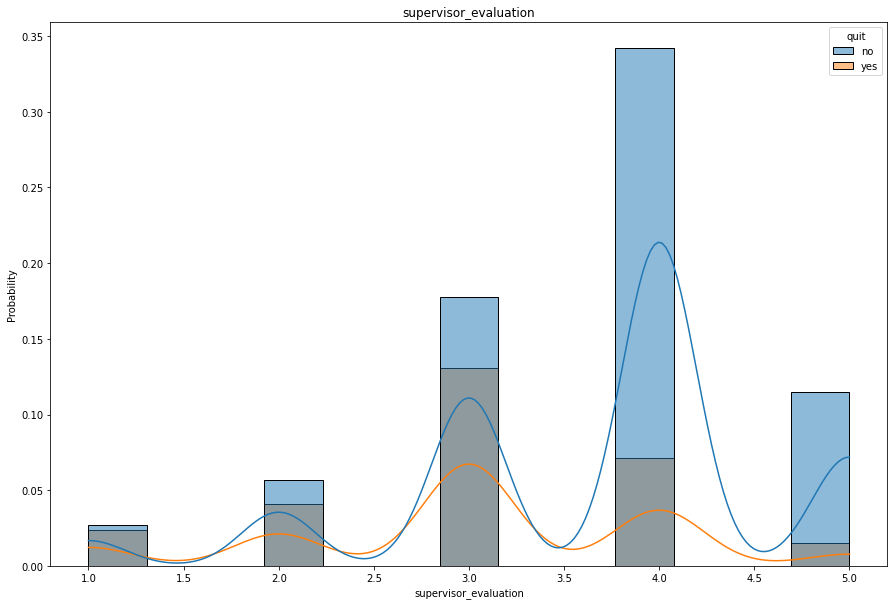

In [60]:
for i in ['salary', 'job_satisfaction_rate', 'employment_years', 'supervisor_evaluation']:
    hist(train_quit, i, 'quit', True, 13, (15,10), 0, 'probability')

* Промежуточные выводы:

1. Видно, что чем выше удовлетворение сотрудников, тем меньше среди них тех, которые уволились. 
2. Чем выше зарплата в группе, тем меньше доля тех, кто уволился в ней. 
3. Чем дольше сотрудник работает, тем меньше шанс, что он уволится. 
4. Чем выше оценка, тем меньше шанс того, что сотрудник уволится. 

Теперь обратим внимание на корреляцию между признаками. 

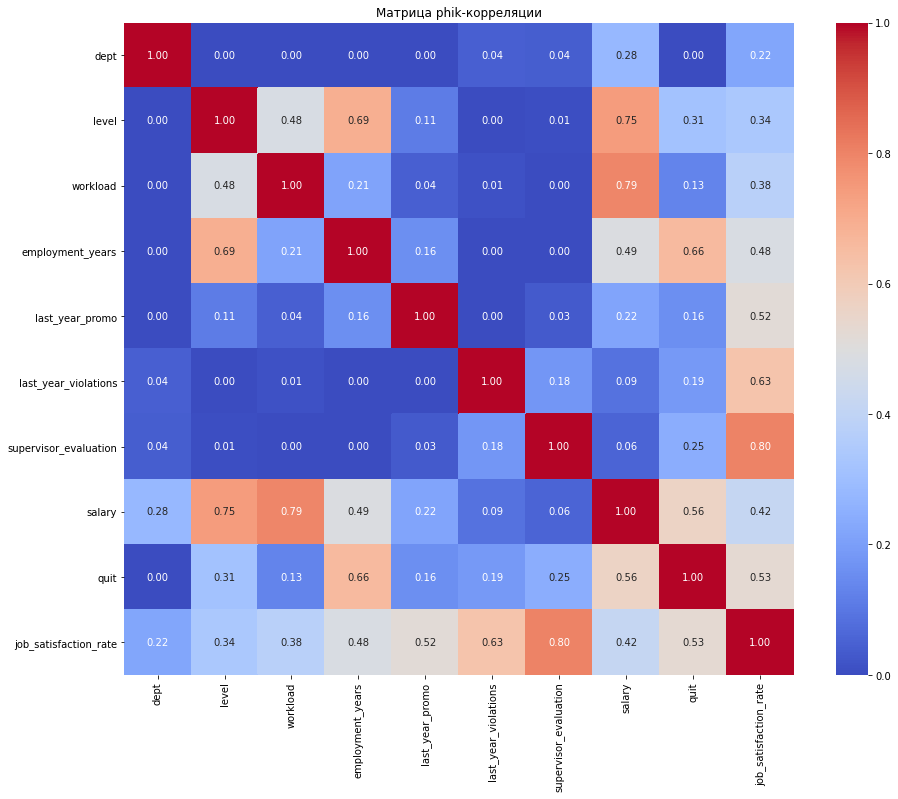

In [61]:
correlation(train_quit,  ['job_satisfaction_rate'])

1. Увольнение средне коррелирует с отработанными годами, уровнем заработной платы и уровнем удовлетворённости. 
2. Мультиколлинеарности признаков не обнаружено. 


**Усреднённое лицо сотрудника, который решил уволиться:**

Это сотрудник с начальным уровнем в кампании, который работает не очень долго в отделе продаж. Уровень его удовлетворённости работой низкий, а нагрузка небольшая. Скорее всего он не получал повышение в предыдущем году. 

### Подготовка данных

Добавим значение удовлетворённости сотрудников в тестовую выборку с помощью нашей модели. 

In [62]:
predictions = randomized_search.best_estimator_.predict(test_features)
test_features['job_satisfaction_rate'] = predictions
test_features

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.829905
1,686555,hr,junior,medium,1,no,no,4,30000,0.675778
2,467458,sales,middle,low,5,no,no,4,19200,0.654167
3,418655,sales,middle,low,6,no,no,4,19200,0.672000
4,789145,hr,middle,medium,5,no,no,5,40800,0.807181
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.512500
1996,109582,technology,middle,low,3,no,no,2,21600,0.135000
1997,305653,technology,junior,low,1,no,no,3,14400,0.240000
1998,160233,technology,middle,low,8,no,no,1,32400,0.405890


In [63]:
df = train_quit.drop('id', axis=1)
X_train =  df.drop(['quit'], axis=1)
y_train = df['quit']

test = pd.merge(test_features,test_target_quit, on = 'id')
test = test.drop(['id'], axis=1)
X_test = test.drop('quit', axis=1)
y_test = test['quit']


X_train.shape,y_train.shape, X_test.shape,y_test.shape

((4000, 9), (4000,), (2000, 9), (2000,))

In [64]:
RANDOM_STATE = 43

target = 'quit'


features = df.columns.drop(target)


num_columns = df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

levels = ['junior', 'middle', 'sinior']
workload = ['low', 'medium', 'high']

ohe_pipe = Pipeline(
    [('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]
    )

ord_levels_pipe = Pipeline(
    [('ord', OrdinalEncoder(categories = [levels], handle_unknown='use_encoded_value', unknown_value=np.nan))
    ]
    )

ord_workload_pipe = Pipeline(
    [('ord', OrdinalEncoder(categories = [workload], handle_unknown='use_encoded_value', unknown_value=np.nan))
    ]
    )

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord_levels', ord_levels_pipe, ['level']),
        ('ord_workload', ord_workload_pipe, ['workload']),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)


pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model',  DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### Обучение моделей

In [65]:
param_grid = [
        
    {
        'model': [LogisticRegression(solver='liblinear', penalty='l1', random_state=RANDOM_STATE)],
        'model__C': range(1,6),        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']  
    },

    
    {
        'model': [SVC(probability=True, random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [DecisionTreeClassifier(random_state=42)],
        'model__max_depth': range(2, 11),
        'model__max_features': range(2, 12),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(pipe_final, 
param_grid, 
cv=5, 
scoring='roc_auc',
random_state=RANDOM_STATE,
n_jobs=-1, 
error_score='raise')

randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print("Лучшее значение метрики (ROC AUC):", randomized_search.best_score_)

y_proba = randomized_search.predict_proba(X_test)[:, 1]  

roc_auc_test = roc_auc_score(y_test, y_proba)

print("Лучшее значение метрики (ROC AUC) на тестовой выборке:", roc_auc_test)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord_levels',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                       

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучше всего себя вновь показало дерево решений. 

Посмотрим как оно приняло решение. 

In [66]:
data_preprocessor.fit_transform(X_train)

best_model = randomized_search.best_estimator_.named_steps['model']
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Признак':pipe_final.named_steps['preprocessor'].get_feature_names_out(), 'Важность': feature_importances})
importance_df = importance_df.sort_values(by='Важность', ascending=False)

importance_df


,Признак,Важность
11,num__job_satisfaction_rate,0.420843
6,ord_levels__level,0.392935
10,num__salary,0.084994
8,num__employment_years,0.060356
7,ord_workload__workload,0.036192
3,ohe__dept_technology,0.002944
4,ohe__last_year_promo_yes,0.001445
1,ohe__dept_purchasing,0.000185
9,num__supervisor_evaluation,0.000108
0,ohe__dept_marketing,0.000000


### Общий вывод

***Общий ход работы:***

**Работа выполнялась в два этапа ключевых этапа:**

1. Вспомогательный. Построение модели регрессии для предсказания удовлетворённости сотрудников. 
2. Основной. Построение модели-классификатора для предсказания увольнения сотрудников. 

Вспомогательный этап был проведён в предположении, что уровень удовлетворения сильно связан с риском увольнения сотрудника. 

* Для выполнения обоих этапов было проведен предворительная предобработка и анализ данных.

**О качестве данных:**

1. В данных отсуствуют выбросы. Выбивающиеся значения зарплат легко объяснились устройством рынка труда. Также легко объяснимы и низкие оценки начальством некоторых сотрудников. 
2. Данные предоставлены в достаточном объёме. 
3. Присуствовал небольшой процент строк с пропусками. 
4. Было предоставлено достаточно примеров искомого класса уволившихся. 
5. Поиск дубликатов не выявил их. 

**Выводы:**

В ходе решения основной задачи, то есть построения модели, которая позволяла бы предсказывать увольнение сотрудника, была подтверждена основаная гипотеза о том, что удовлетворение сотрудников - важный фактор. Чем он выше, тем меньше шанс увольнения. Почти на таком же уровне значимости находится уровень сотрудника. Чем более значимое положение занимает сотрудник, тем с меньшим шансом он уволится. Подавляющее большинство уволившихся сотрудников - сотрудники уровня junior. 

**Рекомендации:**

Исследование показало, что ключевой фактор - социальный, а не материальный. Следует впервую очередь озаботится взаимодействием с младшими сотрудниками. В качества решения могу предложить: 

* Увеличить вовлечённость младщих сотрудников в дела кампании или локального коллектива. Этого можно добиться с помощью, к примеру, предоставления права решать мелкие управленческие задачи. Зачастую даже символические управленческие задачи повышают вовлечённость сотрудника в дела кампании или локального коллектива. 
